In [51]:
import sys
import os
import subprocess
import types
import numpy as np
import imageio
import SimpleITK as sitk
import pandas as pd
import cv2
from skimage.transform import resize

# 1. Mock ProgressBar because it is missing
class MockProgressBar:
    FULL = 'full'
    def __init__(self, n, fmt='full'):
        self.n = n
        self.current = 0
    def __call__(self):
        pass
    def done(self):
        pass

# Inject into sys.modules so 'from ProgressBar import ProgressBar' works
mock_pb_module = types.ModuleType("ProgressBar")
mock_pb_module.ProgressBar = MockProgressBar
sys.modules["ProgressBar"] = mock_pb_module

# 2. Setup TensorFlow 1.x compatibility
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sys.modules['tensorflow'] = tf

# Add current directory to path to allow importing local modules
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

import GAN_tf
print("Setup complete.")

Setup complete.


## Loader for ACDC dataset

In [3]:
def load_acdc_data(base_dir, target_size=(128, 192)):
    training_dir = os.path.join(base_dir, 'database', 'training_test')
    patients = sorted([d for d in os.listdir(training_dir) if os.path.isdir(os.path.join(training_dir, d))])

    all_images = []
    all_flows = []

    print(f"Found {len(patients)} patients.")

    for p in patients:
        p_dir = os.path.join(training_dir, p)
        cfg_path = os.path.join(p_dir, 'Info.cfg')
        if not os.path.exists(cfg_path):
            continue
            
        # Check group
        is_nor = False
        try:
            with open(cfg_path, 'r') as f:
                for line in f:
                    if line.strip().startswith('Group'):
                        if 'NOR' in line:
                            is_nor = True
                        break
        except Exception as e:
            print(f"Error reading config for {p}: {e}")
            continue
        
        if not is_nor:
            continue
            
        print(f"Processing {p} (NOR)...")
        # Load 4D
        nii_path = os.path.join(p_dir, f'{p}_4d.nii.gz')
        if not os.path.exists(nii_path):
             continue
             
        try:
            img_obj = sitk.ReadImage(nii_path)
            img_arr = sitk.GetArrayFromImage(img_obj) # (T, Z, Y, X) or similar. Normally ITK is (x,y,z,t) -> numpy (t,z,y,x)
        except Exception as e:
            print(f"Error loading image for {p}: {e}")
            continue

        if len(img_arr.shape) == 4:
            T, Z, H, W = img_arr.shape
        else:
             # Skip if not 4D
             print(f"Skipping {p}: Shape {img_arr.shape} is not 4D")
             continue
        
        for z in range(Z):
            slice_seq = img_arr[:, z, :, :]  # Shape: (T, H, W)
             
            # --- APPLIED FIX: Robust 1st/99th Percentile Normalization ---
            # 1. Calculate the 1st and 99th percentiles across the whole sequence
            p1 = np.percentile(slice_seq, 1)
            p99 = np.percentile(slice_seq, 99)
            
            # 2. Calculate the range (adding 1e-8 to prevent division by zero)
            slice_range = p99 - p1 + 1e-8

            # Pre-process frames for this slice
            processed_frames = []
            
            for t in range(T):
                frame = slice_seq[t]
            
                # 3. Resize the frame
                frame_resized = cv2.resize(
                    frame.astype(np.float32),
                    (target_size[1], target_size[0])
                )
                    
                # 4. Normalize using the percentiles (NOT the absolute min/max)
                # If the slice is completely empty/black, p99-p1 will be ~0
                if (p99 - p1) < 1e-7:
                    frame_norm = np.zeros(target_size, dtype=np.float32)
                else:
                    frame_norm = (frame_resized - p1) / slice_range
                    
                    # 5. Clip values strictly to [0.0, 1.0] 
                    # ANY outlier pixel brighter than p99 is now forced to exactly 1.0
                    # ANY outlier pixel darker than p1 is now forced to exactly 0.0
                    frame_norm = np.clip(frame_norm, 0.0, 1.0)

                frame_rgb = np.stack([frame_norm] * 3, axis=-1)
                processed_frames.append(frame_rgb)

            # ------------------------------
                    
            processed_frames_arr = np.array(processed_frames) # (T, 128, 192, 3)
             
            # Compute flows and pairs
            for t in range(T-1):
                prev_gray = (processed_frames_arr[t, :, :, 0] * 255).astype(np.uint8)
                next_gray = (processed_frames_arr[t+1, :, :, 0] * 255).astype(np.uint8)
                
                # Calc Dense Optical Flow
                try:
                    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                except Exception as e:
                    print(f"Flow failed: {e}")
                    continue

                # Add Magnitude channel
                mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                flow_3ch = np.dstack((flow, mag)) # (H, W, 3)
                
                all_images.append(processed_frames_arr[t]) 
                all_flows.append(flow_3ch)
                
    return np.array(all_images), np.array(all_flows)

## Loader for MM data

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import SimpleITK as sitk

def load_mm_data(mm_training_dir, csv_path, target_size=(128, 192)):
    """
    Load M&M (Multi-centre, Multi-vendor, Multi-disease) cardiac MRI data.
    Only subjects with Pathology == 'NOR' (normal) are loaded.

    Parameters
    ----------
    mm_training_dir : str
        Path to the M&M Training folder (Dataset_1/Training).
        Expected to contain files like {ID}_sa.nii.gz.
    csv_path : str
        Path to the M&M CSV metadata file
        (211230_M&Ms_Dataset_information_diagnosis_opendataset.csv).
    target_size : tuple
        (H, W) to which every frame is resized. Default matches load_acdc_data.

    Returns
    -------
    all_images : np.ndarray  shape (N, H, W, 3)
    all_flows  : np.ndarray  shape (N, H, W, 3)  [dx, dy, magnitude]
    """
    # Load CSV and build set of NOR subject IDs
    df = pd.read_csv(csv_path)
    nor_ids = set(df[df['Pathology'] == 'NOR']['External code'].tolist())
    print(f"Found {len(nor_ids)} M&M NOR subjects in CSV.")

    all_images = []
    all_flows  = []

    # Gather all short-axis volume files (skip ground-truth masks)
    sa_files = sorted([
        f for f in os.listdir(mm_training_dir)
        if f.endswith('_sa.nii.gz') and not f.endswith('_sa_gt.nii.gz')
    ])

    for fname in sa_files:
        subject_id = fname.replace('_sa.nii.gz', '')
        if subject_id not in nor_ids:
            continue

        print(f"Processing {subject_id} (M&M NOR)...")
        nii_path = os.path.join(mm_training_dir, fname)

        try:
            img_obj = sitk.ReadImage(nii_path)
            img_arr = sitk.GetArrayFromImage(img_obj)  # typically (T, Z, H, W)
        except Exception as e:
            print(f"Error loading {fname}: {e}")
            continue

        if len(img_arr.shape) == 4:
            T, Z, H, W = img_arr.shape
        else:
            print(f"Skipping {subject_id}: unexpected shape {img_arr.shape}")
            continue

        for z in range(Z):
            slice_seq = img_arr[:, z, :, :]  # (T, H, W)

            # --- APPLIED FIX: Robust 1st/99th Percentile Normalization ---
            p1 = np.percentile(slice_seq, 1)
            p99 = np.percentile(slice_seq, 99)
            slice_range = p99 - p1 + 1e-8

            processed_frames = []
            for t in range(T):
                frame = slice_seq[t]
                
                # Resize the frame first
                frame_resized = cv2.resize(
                    frame.astype(np.float32),
                    (target_size[1], target_size[0])
                )
                
                # Normalize using the percentiles
                if p99 - p1 == 0:
                    frame_norm = np.zeros(target_size)
                else:
                    frame_norm = (frame_resized - p1) / slice_range
                    # Clip values strictly to [0.0, 1.0] to crush extreme outliers
                    frame_norm = np.clip(frame_norm, 0.0, 1.0) 

                frame_rgb = np.stack([frame_norm] * 3, axis=-1)
                processed_frames.append(frame_rgb)

            processed_frames_arr = np.array(processed_frames)  # (T, H, W, 3)

            for t in range(T - 1):
                prev_gray = (processed_frames_arr[t,   :, :, 0] * 255).astype(np.uint8)
                next_gray = (processed_frames_arr[t+1, :, :, 0] * 255).astype(np.uint8)

                try:
                    flow = cv2.calcOpticalFlowFarneback(
                        prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0
                    )
                except Exception as e:
                    print(f"Flow failed for {subject_id} z={z} t={t}: {e}")
                    continue

                mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                flow_3ch = np.dstack((flow, mag))  # (H, W, 3)

                all_images.append(processed_frames_arr[t])
                all_flows.append(flow_3ch)

    return np.array(all_images), np.array(all_flows)


def load_combined_data(acdc_dir, mm_training_dir, csv_path, target_size=(128, 192)):
    """
    Load and concatenate NOR patients from both ACDC (Dataset_2) and
    M&M (Dataset_1) datasets.

    Parameters
    ----------
    acdc_dir       : str    root of Dataset_2 (contains 'database/training')
    mm_training_dir: str    Dataset_1/Training folder
    csv_path       : str    M&M CSV metadata file path
    target_size    : tuple  (H, W) resize target, default (128, 192)

    Returns
    -------
    images : np.ndarray  shape (N_acdc + N_mm, H, W, 3)
    flows  : np.ndarray  shape (N_acdc + N_mm, H, W, 3)
    """
    print("=== Loading ACDC NOR data ===")
    acdc_images, acdc_flows = load_acdc_data(acdc_dir, target_size)
    print(f"ACDC NOR samples: {len(acdc_images)}")

    print("\n=== Loading M&M NOR data ===")
    mm_images, mm_flows = load_mm_data(mm_training_dir, csv_path, target_size)
    print(f"M&M NOR samples:  {len(mm_images)}")

    if len(acdc_images) == 0 and len(mm_images) == 0:
        return np.array([]), np.array([])
    elif len(acdc_images) == 0:
        return mm_images, mm_flows
    elif len(mm_images) == 0:
        return acdc_images, acdc_flows

    images = np.concatenate([acdc_images, mm_images], axis=0)
    flows  = np.concatenate([acdc_flows,  mm_flows],  axis=0)
    print(f"\nCombined: {len(images)} samples total")
    return images, flows


## Trainings

In [6]:
# ── Combined ACDC + M&M training ────────────────────────────────────────────
acdc_dir       = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"
mm_training_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/Training"
mm_csv_path     = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"

try:
    images, flows = load_combined_data(acdc_dir, mm_training_dir, mm_csv_path)
    print(f"\nLoaded {len(images)} samples in total.")

    if len(images) > 0:
        print(f"Images shape: {images.shape}")
        print(f"Flows  shape: {flows.shape}")

        tf.compat.v1.reset_default_graph()

        print("\nStarting Training (ACDC + M&M combined)...")
        GAN_tf.train_Unet_naive_with_batch_norm(
            training_images=images,
            training_flows=flows,
            max_epoch=2,
            dataset_name='ACDC_MM_test',
            batch_size=4
        )
        print("Training complete.")
    else:
        print("No data loaded. Check dataset paths and NOR filtering.")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


=== Loading ACDC NOR data ===
Found 100 patients.
Processing patient061 (NOR)...
Processing patient062 (NOR)...
Processing patient063 (NOR)...
Processing patient064 (NOR)...
Processing patient065 (NOR)...
Processing patient066 (NOR)...
Processing patient067 (NOR)...
Processing patient068 (NOR)...
Processing patient069 (NOR)...
Processing patient070 (NOR)...
Processing patient071 (NOR)...
Processing patient072 (NOR)...
Processing patient073 (NOR)...
Processing patient074 (NOR)...
Processing patient075 (NOR)...
Processing patient076 (NOR)...
Processing patient077 (NOR)...
Processing patient078 (NOR)...
Processing patient079 (NOR)...
Processing patient080 (NOR)...
ACDC NOR samples: 4711

=== Loading M&M NOR data ===
Found 89 M&M NOR subjects in CSV.
Processing A2N8V0 (M&M NOR)...
Processing A3B7E5 (M&M NOR)...
Processing A3H1O5 (M&M NOR)...
Processing A4U9V5 (M&M NOR)...
Processing A8C9H8 (M&M NOR)...
Processing A8I1U6 (M&M NOR)...
Processing A9J8W7 (M&M NOR)...
Processing B1K7U1 (M&M NOR

c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:119: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  d = tf.layers.batch_normalization(d, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:127: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  u = tf.layers.batch_normalization(u, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learn

Run: tensorboard --logdir logs/2
epoch 1/2, iter   1/4516: D_loss = 0.8009, G_loss = 0.8027, loss_appe = 0.7468, loss_flow = 0.2441
epoch 1/2, iter   2/4516: D_loss = 0.7998, G_loss = 0.7980, loss_appe = 0.6052, loss_flow = 0.2057


KeyboardInterrupt: 

In [3]:
# Parameters
base_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"

print("Loading ACDC Data...")

images, flows = load_acdc_data(base_dir)
print(f"Loaded {len(images)} samples.")


print(f"Images shape: {images.shape}")
print(f"Flows shape: {flows.shape}")

Loading ACDC Data...
Found 4 patients.
Processing patient061 (NOR)...
Processing patient062 (NOR)...
Loaded 551 samples.
Images shape: (551, 128, 192, 3)
Flows shape: (551, 128, 192, 3)


In [5]:
flows.max()

4.428835

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66076946..1.4430022].


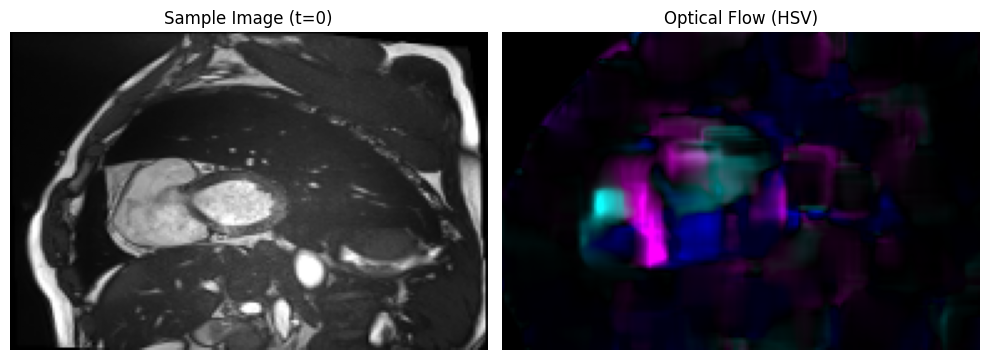

In [10]:
# visualize flow[0] and its images:
import matplotlib.pyplot as plt
# import mcolors for HSV to RGB conversion
import matplotlib.colors as mcolors

# Pick the first sample
sample_img = images[0]  # (128, 192, 3)
sample_flow = flows[0]   # (128, 192, 3) ->
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_img[..., 0], cmap='gray')  # Show the
axes[0].set_title("Sample Image (t=0)")
axes[0].axis('off')
axes[1].imshow(sample_flow)
axes[1].set_title("Optical Flow (HSV)")
axes[1].axis('off')
plt.tight_layout()
plt.show()


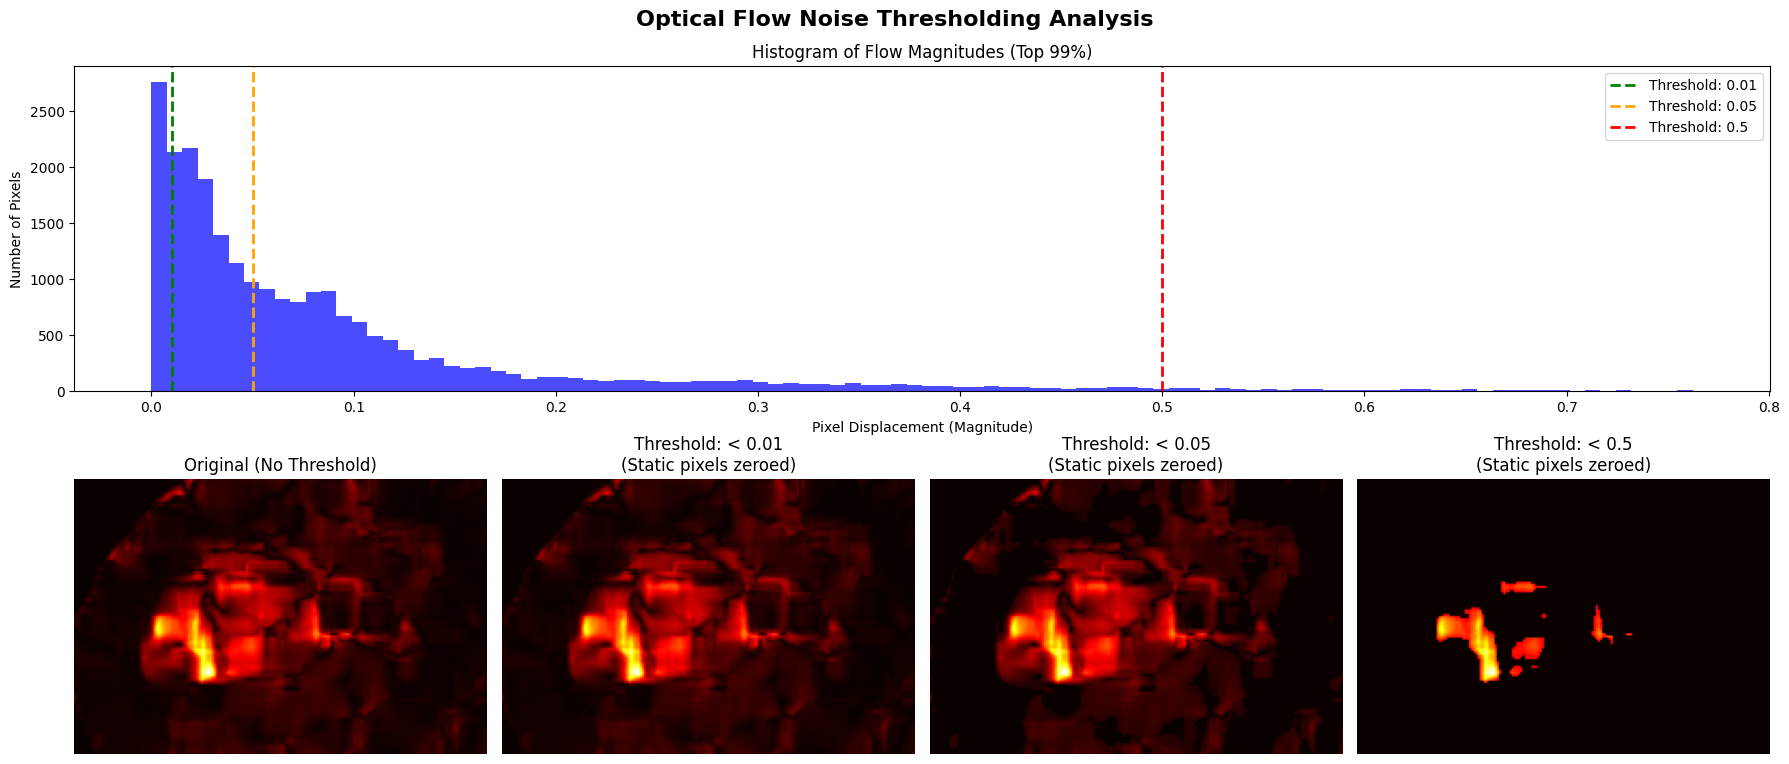

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_flow_thresholds(flow_3ch):
    """
    Plots a histogram of flow magnitudes and compares different noise thresholds.
    Assumes flow_3ch is shape (H, W, 3) where index 2 is the magnitude.
    """
    # Extract just the magnitude channel
    mag = flow_3ch[..., 2]
    
    # Define the thresholds we want to test
    thresholds = [0.01, 0.05, 0.5]
    
    # Create the figure layout
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("Optical Flow Noise Thresholding Analysis", fontsize=16, fontweight='bold')

    # --- Plot 1: The Histogram ---
    # 
    ax_hist = plt.subplot(2, 4, (1, 4)) # Span the top row
    ax_hist.hist(mag.flatten(), bins=100, range=(0.0, np.percentile(mag, 99)), color='blue', alpha=0.7)
    ax_hist.set_title("Histogram of Flow Magnitudes (Top 99%)")
    ax_hist.set_xlabel("Pixel Displacement (Magnitude)")
    ax_hist.set_ylabel("Number of Pixels")
    
    # Draw vertical lines for our thresholds on the histogram
    colors = ['green', 'orange', 'red']
    for t, c in zip(thresholds, colors):
        ax_hist.axvline(x=t, color=c, linestyle='dashed', linewidth=2, label=f'Threshold: {t}')
    ax_hist.legend()

    # --- Plot 2: Original Flow Magnitude ---
    ax_orig = plt.subplot(2, 4, 5)
    ax_orig.imshow(mag, cmap='hot')
    ax_orig.set_title("Original (No Threshold)")
    ax_orig.axis('off')

    # --- Plots 3, 4, 5: Thresholded Flows ---
    # 
    for i, (t, c) in enumerate(zip(thresholds, colors)):
        ax_thresh = plt.subplot(2, 4, 6 + i)
        
        # Apply the threshold logically: if less than t, set to 0.0, else keep original
        clean_mag = np.where(mag < t, 0.0, mag)
        
        ax_thresh.imshow(clean_mag, cmap='hot')
        ax_thresh.set_title(f"Threshold: < {t}\n(Static pixels zeroed)")
        ax_thresh.axis('off')

    plt.tight_layout()
    plt.show()

# --- How to use it ---
# Assuming 'all_flows' is the array returned by your loading function:
# Pick a frame where the heart is actively moving (e.g., frame 10 or 15)
visualize_flow_thresholds(flows[0])

In [5]:
flows

array([], dtype=float64)

In [3]:
# Parameters
base_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"

print("Loading ACDC Data...")
try:
    images, flows = load_acdc_data(base_dir)
    print(f"Loaded {len(images)} samples.")
    
    if len(images) > 0:
        print(f"Images shape: {images.shape}")
        print(f"Flows shape: {flows.shape}")
        
        # To reset defaul graph, this is something from tensorflow1
        tf.compat.v1.reset_default_graph() 
        
        # Train
        print("Starting Training...")
        GAN_tf.train_Unet_naive_with_batch_norm(
            training_images=images,
            training_flows=flows,
            max_epoch=2,
            dataset_name='ACDC_test',
            batch_size=4
        )
        print("Training complete.")
    else:
        print("No data loaded. Check paths and group='NOR'.")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Loading ACDC Data...
Found 4 patients.
Processing patient061 (NOR)...
Processing patient062 (NOR)...
Loaded 551 samples.
Images shape: (551, 128, 192, 3)
Flows shape: (551, 128, 192, 3)

Starting Training...
no. of images = 551


Instructions for updating:
Colocations handled automatically by placer.


c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:145: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  d = tf.layers.batch_normalization(d, training=training)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:153: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  u = tf.layers.batch_normalization(u, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:202: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  d = tf.layers.batch_normalization(d, training=training)




Run: tensorboard --logdir logs/2
epoch 1/2, iter   1/138: D_loss = 0.8036, G_loss = 0.8039, loss_appe = 1.0077, loss_flow = 0.2648
epoch 1/2, iter   2/138: D_loss = 0.8031, G_loss = 0.8020, loss_appe = 0.8826, loss_flow = 0.2204
epoch 1/2, iter   3/138: D_loss = 0.8014, G_loss = 0.7976, loss_appe = 0.7193, loss_flow = 0.1786
epoch 1/2, iter   4/138: D_loss = 0.8007, G_loss = 0.7957, loss_appe = 0.5925, loss_flow = 0.1508
epoch 1/2, iter   5/138: D_loss = 0.8003, G_loss = 0.7953, loss_appe = 0.5121, loss_flow = 0.1427
epoch 1/2, iter   6/138: D_loss = 0.7998, G_loss = 0.7908, loss_appe = 0.4185, loss_flow = 0.1268
epoch 1/2, iter   7/138: D_loss = 0.8017, G_loss = 0.7957, loss_appe = 0.4505, loss_flow = 0.1228
epoch 1/2, iter   8/138: D_loss = 0.7990, G_loss = 0.7916, loss_appe = 0.3817, loss_flow = 0.1225
epoch 1/2, iter   9/138: D_loss = 0.8029, G_loss = 0.7968, loss_appe = 0.4171, loss_flow = 0.1050
epoch 1/2, iter  10/138: D_loss = 0.7997, G_loss = 0.7925, loss_appe = 0.3545, loss

KeyboardInterrupt: 

## Using only ES and ED

In [55]:
# ── ED/ES-only combined data loader ──────────────────────────────────────────
# Loads NOR subjects from ACDC (Dataset_2) and M&M (Dataset_1).
# For each subject and each z-slice:
#   • input image  = End-Systole (ES) frame
#   • next frame   = End-Diastole (ED) frame
# Optical flow is computed from ES → ED.

def load_combined_ed_es_data(acdc_dir, mm_training_dir, csv_path,
                              target_size=(128, 192)):
    """
    Load only End-Diastole (ED) and End-Systole (ES) frame pairs
    from both ACDC (Dataset_2) and M&M (Dataset_1) NOR subjects.

    Parameters
    ----------
    acdc_dir        : str   Root of Dataset_2 (contains 'database/training').
    mm_training_dir : str   Dataset_1/Training folder.
    csv_path        : str   M&M CSV metadata file path.
    target_size     : tuple (H, W) resize target, default (128, 192).

    Returns
    -------
    all_images : np.ndarray  shape (N, H, W, 3)  – ES frames (input)
    all_flows  : np.ndarray  shape (N, H, W, 3)  – optical flow ES→ED
    """

    def _preprocess_frame(frame, p1, p99, target_size):
        """Resize + percentile-normalise a single 2-D frame to RGB."""
        frame_resized = cv2.resize(
            frame.astype(np.float32),
            (target_size[1], target_size[0])
        )
        if (p99 - p1) < 1e-7:
            frame_norm = np.zeros(target_size, dtype=np.float32)
        else:
            frame_norm = np.clip((frame_resized - p1) / (p99 - p1 + 1e-8),
                                 0.0, 1.0)
        return np.stack([frame_norm] * 3, axis=-1)  # (H, W, 3)

    all_images = []
    all_flows  = []

    # ── ACDC ────────────────────────────────────────────────────────────────
    training_dir = os.path.join(acdc_dir, 'database', 'training')
    if not os.path.isdir(training_dir):
        # fallback used by earlier experiments
        training_dir = os.path.join(acdc_dir, 'database', 'training_test')
    patients = sorted([d for d in os.listdir(training_dir)
                       if os.path.isdir(os.path.join(training_dir, d))])
    print(f"ACDC: found {len(patients)} patient folders.")

    for p in patients:
        p_dir    = os.path.join(training_dir, p)
        cfg_path = os.path.join(p_dir, 'Info.cfg')
        if not os.path.exists(cfg_path):
            continue

        # Read Group, ED, ES from Info.cfg
        info = {}
        try:
            with open(cfg_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if ':' in line:
                        key, val = line.split(':', 1)
                        info[key.strip()] = val.strip()
        except Exception as e:
            print(f"Cannot read config for {p}: {e}")
            continue

        if info.get('Group', '') != 'NOR':
            continue

        try:
            ed_idx = int(info['ED'])
            es_idx = int(info['ES'])
        except (KeyError, ValueError) as e:
            print(f"Missing ED/ES in {p}: {e}")
            continue
        if ed_idx == es_idx:
            print(f"Skipping ACDC {p}: ED and ES frames are identical ({ed_idx})")
            continue
        
        nii_path = os.path.join(p_dir, f'{p}_4d.nii.gz')
        if not os.path.exists(nii_path):
            continue

        try:
            img_arr = sitk.GetArrayFromImage(sitk.ReadImage(nii_path))  # (T,Z,H,W)
        except Exception as e:
            print(f"Load error {p}: {e}")
            continue

        if img_arr.ndim != 4:
            continue
        T, Z, _, _ = img_arr.shape

        if es_idx >= T or ed_idx >= T:
            print(f"Skipping {p}: ED={ed_idx} or ES={es_idx} out of range T={T}")
            continue

        print(f"ACDC {p} (NOR)  ED={ed_idx}  ES={es_idx}")
        for z in range(Z):
            slice_seq = img_arr[:, z, :, :]  # (T, H, W)
            p1  = np.percentile(slice_seq, 1)
            p99 = np.percentile(slice_seq, 99)

            es_frame_rgb = _preprocess_frame(slice_seq[es_idx], p1, p99, target_size)
            ed_frame_rgb = _preprocess_frame(slice_seq[ed_idx], p1, p99, target_size)

            es_gray = (es_frame_rgb[:, :, 0] * 255).astype(np.uint8)
            ed_gray = (ed_frame_rgb[:, :, 0] * 255).astype(np.uint8)

            try:
                flow = cv2.calcOpticalFlowFarneback(
                    es_gray, ed_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            except Exception as e:
                print(f"Flow error {p} z={z}: {e}")
                continue

            mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            flow_3ch = np.dstack((flow, mag))  # (H, W, 3)

            all_images.append(es_frame_rgb)
            all_flows.append(flow_3ch)

    print(f"ACDC NOR ED/ES samples: {len(all_images)}")
    acdc_count = len(all_images)

    # ── M&M ─────────────────────────────────────────────────────────────────
    df = pd.read_csv(csv_path)
    # Build lookup: subject_id -> (ed_idx, es_idx)
    nor_rows = df[df['Pathology'] == 'NOR'][['External code', 'ED', 'ES']]
    nor_info = {row['External code']: (int(row['ED']), int(row['ES']))
                for _, row in nor_rows.iterrows()}
    print(f"M&M: found {len(nor_info)} NOR subjects in CSV.")

    sa_files = sorted([f for f in os.listdir(mm_training_dir)
                       if f.endswith('_sa.nii.gz') and not f.endswith('_sa_gt.nii.gz')])

    for fname in sa_files:
        subject_id = fname.replace('_sa.nii.gz', '')
        if subject_id not in nor_info:
            continue

        ed_idx, es_idx = nor_info[subject_id]
        nii_path = os.path.join(mm_training_dir, fname)

        try:
            img_arr = sitk.GetArrayFromImage(sitk.ReadImage(nii_path))  # (T,Z,H,W)
        except Exception as e:
            print(f"Load error {subject_id}: {e}")
            continue

        if img_arr.ndim != 4:
            continue
        T, Z, _, _ = img_arr.shape

        if es_idx >= T or ed_idx >= T:
            print(f"Skipping {subject_id}: ED={ed_idx} or ES={es_idx} out of range T={T}")
            continue

        print(f"M&M {subject_id} (NOR)  ED={ed_idx}  ES={es_idx}")
        for z in range(Z):
            slice_seq = img_arr[:, z, :, :]  # (T, H, W)
            p1  = np.percentile(slice_seq, 1)
            p99 = np.percentile(slice_seq, 99)

            es_frame_rgb = _preprocess_frame(slice_seq[es_idx], p1, p99, target_size)
            ed_frame_rgb = _preprocess_frame(slice_seq[ed_idx], p1, p99, target_size)

            es_gray = (es_frame_rgb[:, :, 0] * 255).astype(np.uint8)
            ed_gray = (ed_frame_rgb[:, :, 0] * 255).astype(np.uint8)

            try:
                flow = cv2.calcOpticalFlowFarneback(
                    es_gray, ed_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            except Exception as e:
                print(f"Flow error {subject_id} z={z}: {e}")
                continue

            mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            flow_3ch = np.dstack((flow, mag))

            all_images.append(es_frame_rgb)
            all_flows.append(flow_3ch)

    mm_count = len(all_images) - acdc_count
    print(f"M&M NOR ED/ES samples: {mm_count}")
    print(f"Combined ED/ES samples: {len(all_images)}")

    if len(all_images) == 0:
        return np.array([]), np.array([])
    return np.array(all_images), np.array(all_flows)


In [56]:
# ── Train on combined ED/ES pairs (ES → ED) ──────────────────────────────────
# Input  : End-Systole  (ES) frame per z-slice
# Target : End-Diastole (ED) frame per z-slice  (used as "next frame" by GAN)
# Flow   : optical flow computed ES → ED

acdc_dir        = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"
mm_training_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/Training"
mm_csv_path     = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"

images_ed_es, flows_ed_es = load_combined_ed_es_data(
    acdc_dir, mm_training_dir, mm_csv_path
)

ACDC: found 100 patient folders.
ACDC patient061 (NOR)  ED=1  ES=10
ACDC patient062 (NOR)  ED=1  ES=9
ACDC patient063 (NOR)  ED=1  ES=16
ACDC patient064 (NOR)  ED=1  ES=12
ACDC patient065 (NOR)  ED=1  ES=14
ACDC patient066 (NOR)  ED=1  ES=11
ACDC patient067 (NOR)  ED=1  ES=10
ACDC patient068 (NOR)  ED=1  ES=12
ACDC patient069 (NOR)  ED=1  ES=12
ACDC patient070 (NOR)  ED=1  ES=10
ACDC patient071 (NOR)  ED=1  ES=9
ACDC patient072 (NOR)  ED=1  ES=11
ACDC patient073 (NOR)  ED=1  ES=10
ACDC patient074 (NOR)  ED=1  ES=12
ACDC patient075 (NOR)  ED=1  ES=6
ACDC patient076 (NOR)  ED=1  ES=12
ACDC patient077 (NOR)  ED=1  ES=9
ACDC patient078 (NOR)  ED=1  ES=9
ACDC patient079 (NOR)  ED=1  ES=11
ACDC patient080 (NOR)  ED=1  ES=10
ACDC NOR ED/ES samples: 170
M&M: found 89 NOR subjects in CSV.
M&M A2N8V0 (NOR)  ED=0  ES=9
M&M A3B7E5 (NOR)  ED=29  ES=12
M&M A3H1O5 (NOR)  ED=0  ES=12
M&M A4U9V5 (NOR)  ED=0  ES=8
M&M A8C9H8 (NOR)  ED=0  ES=0
M&M A8I1U6 (NOR)  ED=0  ES=0
M&M A9J8W7 (NOR)  ED=29  ES=10
M

Loaded 6 ED/ES pairs for display.


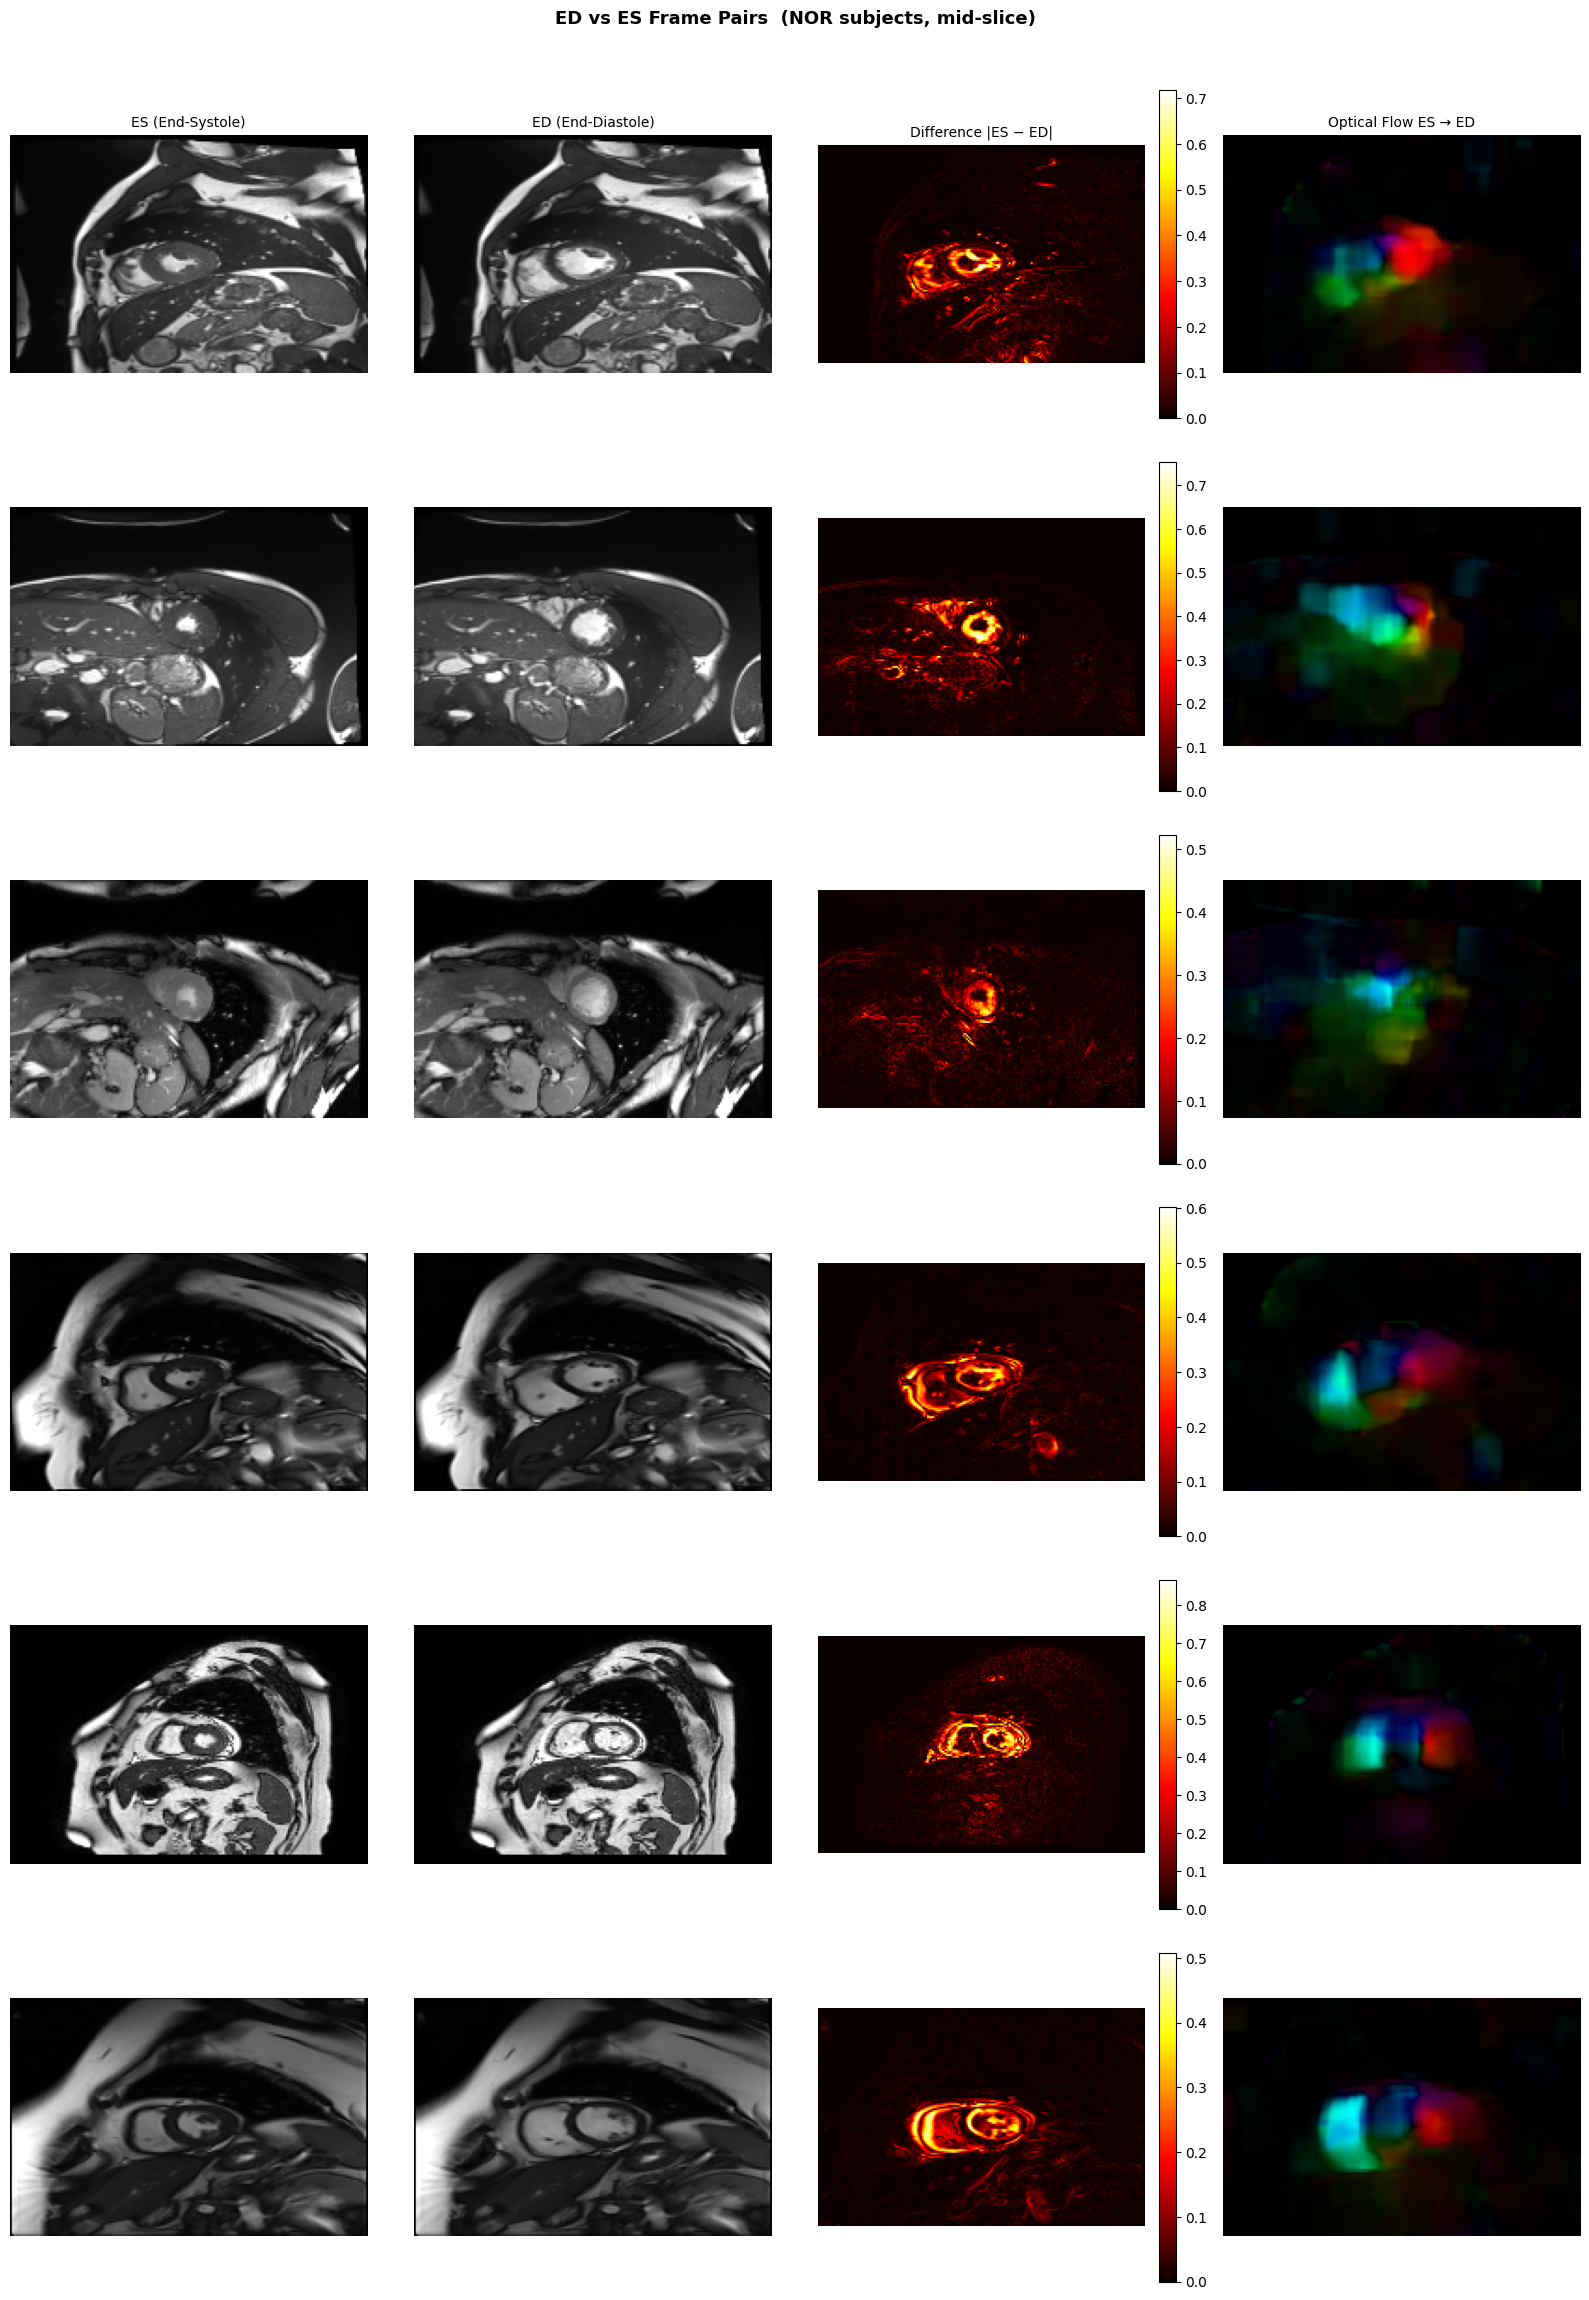

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# =============================================================================
# Visualise ED and ES frames from both datasets
# =============================================================================
# We re-load a few subjects to grab both ED and ES frames for display,
# since the data loader only kept the ES frames as input images.

def load_ed_es_pairs_for_display(acdc_dir, mm_dir, csv_path,
                                  target_size=(128, 192),
                                  max_subjects=3):
    """Load (ES, ED) pairs + flow for a handful of NOR subjects."""
    pairs = []  # list of dict: subject_id, dataset, z, es_img, ed_img, flow

    def _prep(frame, p1, p99, sz):
        fr = cv2.resize(frame.astype(np.float32), (sz[1], sz[0]))
        if (p99 - p1) < 1e-7:
            return np.zeros((*sz, 3), np.float32)
        fn = np.clip((fr - p1) / (p99 - p1 + 1e-8), 0, 1)
        return np.stack([fn]*3, -1)

    # ── ACDC ─────────────────────────────────────────────────────────────
    tr_dir = os.path.join(acdc_dir, 'database', 'training')
    if not os.path.isdir(tr_dir):
        tr_dir = os.path.join(acdc_dir, 'database', 'training_test')
    patients = sorted([d for d in os.listdir(tr_dir)
                       if os.path.isdir(os.path.join(tr_dir, d))])
    acdc_n = 0
    for p in patients:
        if acdc_n >= max_subjects:
            break
        p_dir = os.path.join(tr_dir, p)
        cfg = os.path.join(p_dir, 'Info.cfg')
        if not os.path.exists(cfg):
            continue
        info = {}
        with open(cfg) as f:
            for line in f:
                if ':' in line:
                    k, v = line.split(':', 1)
                    info[k.strip()] = v.strip()
        if info.get('Group', '') != 'NOR':
            continue
        try:
            ed_i, es_i = int(info['ED']), int(info['ES'])
        except (KeyError, ValueError):
            continue
        if ed_idx == es_idx:
            print(f"Skipping ACDC {p}: ED and ES frames are identical ({ed_idx})")
            continue
        
        nii = os.path.join(p_dir, f'{p}_4d.nii.gz')
        if not os.path.exists(nii):
            continue
        arr = sitk.GetArrayFromImage(sitk.ReadImage(nii))
        if arr.ndim != 4:
            continue
        T, Z, _, _ = arr.shape
        if es_i >= T or ed_i >= T:
            continue
        mid_z = Z // 2  # pick the middle slice
        sl = arr[:, mid_z, :, :]
        p1, p99 = np.percentile(sl, 1), np.percentile(sl, 99)
        es_img = _prep(sl[es_i], p1, p99, target_size)
        ed_img = _prep(sl[ed_i], p1, p99, target_size)
        g_es = (es_img[:,:,0]*255).astype(np.uint8)
        g_ed = (ed_img[:,:,0]*255).astype(np.uint8)
        flow = cv2.calcOpticalFlowFarneback(g_es, g_ed, None, 0.5,3,15,3,5,1.2,0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        pairs.append({'id': p, 'ds': 'ACDC', 'z': mid_z,
                      'ed_i': ed_i, 'es_i': es_i,
                      'es': es_img, 'ed': ed_img,
                      'flow': flow, 'mag': mag, 'ang': ang})
        acdc_n += 1

    # ── M&M ──────────────────────────────────────────────────────────────
    df = pd.read_csv(csv_path)
    nor = df[df['Pathology']=='NOR']
    nor_info = {r['External code']:(int(r['ED']),int(r['ES']))
                for _,r in nor.iterrows()}
    sa_files = sorted([f for f in os.listdir(mm_dir)
                       if f.endswith('_sa.nii.gz')
                       and not f.endswith('_sa_gt.nii.gz')])
    mm_n = 0
    for fname in sa_files:
        if mm_n >= max_subjects:
            break
        sid = fname.replace('_sa.nii.gz','')
        if sid not in nor_info:
            continue
        ed_i, es_i = nor_info[sid]
        arr = sitk.GetArrayFromImage(
              sitk.ReadImage(os.path.join(mm_dir, fname)))
        if arr.ndim != 4:
            continue
        T, Z, _, _ = arr.shape
        if es_i >= T or ed_i >= T:
            continue
        mid_z = Z // 2
        sl = arr[:, mid_z, :, :]
        p1, p99 = np.percentile(sl, 1), np.percentile(sl, 99)
        es_img = _prep(sl[es_i], p1, p99, target_size)
        ed_img = _prep(sl[ed_i], p1, p99, target_size)
        g_es = (es_img[:,:,0]*255).astype(np.uint8)
        g_ed = (ed_img[:,:,0]*255).astype(np.uint8)
        flow = cv2.calcOpticalFlowFarneback(g_es, g_ed, None, 0.5,3,15,3,5,1.2,0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        pairs.append({'id': sid, 'ds': 'M&M', 'z': mid_z,
                      'ed_i': ed_i, 'es_i': es_i,
                      'es': es_img, 'ed': ed_img,
                      'flow': flow, 'mag': mag, 'ang': ang})
        mm_n += 1

    return pairs

# ── Load pairs ──────────────────────────────────────────────────────────────
acdc_dir    = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"
mm_dir      = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/Training"
mm_csv_path = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"

pairs = load_ed_es_pairs_for_display(acdc_dir, mm_dir, mm_csv_path,
                                      max_subjects=3)
print(f"Loaded {len(pairs)} ED/ES pairs for display.")

# ── Plot ────────────────────────────────────────────────────────────────────
N = len(pairs)
fig, axes = plt.subplots(N, 4, figsize=(16, 3.8 * N))
if N == 1:
    axes = axes[np.newaxis, :]

col_titles = ['ES (End-Systole)', 'ED (End-Diastole)',
              'Difference |ES − ED|', 'Optical Flow ES → ED']

for row, p in enumerate(pairs):
    # difference map
    diff = np.mean(np.abs(p['es'] - p['ed']), axis=-1)

    # optical flow as HSV
    hsv = np.zeros((*p['mag'].shape, 3), dtype=np.float32)
    hsv[..., 0] = p['ang'] / (2 * np.pi)
    hsv[..., 1] = 1.0
    hsv[..., 2] = p['mag'] / (np.max(p['mag']) + 1e-8)
    flow_rgb = mcolors.hsv_to_rgb(hsv)

    imgs = [p['es'], p['ed'], diff, flow_rgb]
    cmaps = [None, None, 'hot', None]

    label = (f"{p['ds']} {p['id']}  z={p['z']}  "
             f"ES=frame {p['es_i']}  ED=frame {p['ed_i']}")

    for col in range(4):
        ax = axes[row, col]
        if cmaps[col]:
            im = ax.imshow(imgs[col], cmap=cmaps[col])
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.imshow(np.clip(imgs[col], 0, 1))
        if row == 0:
            ax.set_title(col_titles[col], fontsize=10)
        ax.axis('off')

    axes[row, 0].set_ylabel(label, fontsize=7.5, rotation=0,
                             labelpad=160, va='center')

plt.suptitle('ED vs ES Frame Pairs  (NOR subjects, mid-slice)',
             fontweight='bold', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


In [46]:
# ── Train on combined ED/ES pairs (ES → ED) ──────────────────────────────────
# Input  : End-Systole  (ES) frame per z-slice
# Target : End-Diastole (ED) frame per z-slice  (used as "next frame" by GAN)
# Flow   : optical flow computed ES → ED

acdc_dir        = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"
mm_training_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/Training"
mm_csv_path     = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"

try:
    images_ed_es, flows_ed_es = load_combined_ed_es_data(
        acdc_dir, mm_training_dir, mm_csv_path
    )
    print(f"\nLoaded {len(images_ed_es)} ED/ES samples in total.")

    if len(images_ed_es) > 0:
        print(f"Images shape : {images_ed_es.shape}")
        print(f"Flows  shape : {flows_ed_es.shape}")

        tf.compat.v1.reset_default_graph()

        print("\nStarting Training (ED/ES combined, ES→ED)...")
        GAN_tf.train_Unet_naive_with_batch_norm(
            training_images=images_ed_es,
            training_flows=flows_ed_es,
            max_epoch=2,
            dataset_name='ACDC_MM_EDES', 
            batch_size=4
        )
        print("Training complete.")
    else:
        print("No data loaded. Check dataset paths and NOR filtering.")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


ACDC: found 100 patient folders.
ACDC patient061 (NOR)  ED=1  ES=10
ACDC patient062 (NOR)  ED=1  ES=9
ACDC patient063 (NOR)  ED=1  ES=16
ACDC patient064 (NOR)  ED=1  ES=12
ACDC patient065 (NOR)  ED=1  ES=14
ACDC patient066 (NOR)  ED=1  ES=11
ACDC patient067 (NOR)  ED=1  ES=10
ACDC patient068 (NOR)  ED=1  ES=12
ACDC patient069 (NOR)  ED=1  ES=12
ACDC patient070 (NOR)  ED=1  ES=10
ACDC patient071 (NOR)  ED=1  ES=9
ACDC patient072 (NOR)  ED=1  ES=11
ACDC patient073 (NOR)  ED=1  ES=10
ACDC patient074 (NOR)  ED=1  ES=12
ACDC patient075 (NOR)  ED=1  ES=6
ACDC patient076 (NOR)  ED=1  ES=12
ACDC patient077 (NOR)  ED=1  ES=9
ACDC patient078 (NOR)  ED=1  ES=9
ACDC patient079 (NOR)  ED=1  ES=11
ACDC patient080 (NOR)  ED=1  ES=10
ACDC NOR ED/ES samples: 170
M&M: found 89 NOR subjects in CSV.
M&M A2N8V0 (NOR)  ED=0  ES=9
M&M A3B7E5 (NOR)  ED=29  ES=12
M&M A3H1O5 (NOR)  ED=0  ES=12
M&M A4U9V5 (NOR)  ED=0  ES=8
M&M A8C9H8 (NOR)  ED=0  ES=0
M&M A8I1U6 (NOR)  ED=0  ES=0
M&M A9J8W7 (NOR)  ED=29  ES=10
M

c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:145: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  d = tf.layers.batch_normalization(d, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:153: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  u = tf.layers.batch_normalization(u, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learn


Device mapping: no known devices.
Run: tensorboard --logdir logs/2
epoch 1/2, iter   1/171: D_loss = 0.8000, G_loss = 0.8043, loss_appe = 1.3064, loss_flow = 0.3620
epoch 1/2, iter   2/171: D_loss = 0.7991, G_loss = 0.8014, loss_appe = 1.2926, loss_flow = 0.2739
epoch 1/2, iter   3/171: D_loss = 0.7955, G_loss = 0.7995, loss_appe = 0.9372, loss_flow = 0.3622
epoch 1/2, iter   4/171: D_loss = 0.7994, G_loss = 0.7998, loss_appe = 1.0007, loss_flow = 0.2417
epoch 1/2, iter   5/171: D_loss = 0.7978, G_loss = 0.7961, loss_appe = 0.9332, loss_flow = 0.1966
epoch 1/2, iter   6/171: D_loss = 0.7971, G_loss = 0.7959, loss_appe = 0.7718, loss_flow = 0.3096
epoch 1/2, iter   7/171: D_loss = 0.7938, G_loss = 0.7989, loss_appe = 0.7788, loss_flow = 0.2255
epoch 1/2, iter   8/171: D_loss = 0.7939, G_loss = 0.7946, loss_appe = 0.7423, loss_flow = 0.2860
epoch 1/2, iter   9/171: D_loss = 0.7929, G_loss = 0.7914, loss_appe = 0.6495, loss_flow = 0.1933
epoch 1/2, iter  10/171: D_loss = 0.7950, G_loss =

KeyboardInterrupt: 

## Plot the logs


Loading .\train_results_2\events.out.tfevents.1771950618.cx3-20-5...

Metrics found in file: ['D_loss', 'G_loss', 'appe_loss', 'opt_loss']

=== AVERAGE LOSS PER EPOCH ===
    epoch    D_loss    G_loss  appe_loss  opt_loss
0       1  0.736195  0.720098   0.174407  0.044062
1       2  0.721673  0.708982   0.127511  0.040984
2       3  0.718068  0.707921   0.117530  0.040747
3       4  0.716118  0.707366   0.112342  0.039922
4       5  0.713888  0.706284   0.108212  0.039636
5       6  0.712900  0.705987   0.104573  0.039180
6       7  0.711388  0.705221   0.102184  0.038832
7       8  0.710815  0.705458   0.100038  0.039033
8       9  0.710446  0.705697   0.098299  0.039078
9      10  0.709107  0.704186   0.096986  0.038266
10     11  0.708241  0.703694   0.096214  0.037849
11     12  0.707900  0.703532   0.094593  0.037888
12     13  0.707046  0.702854   0.093993  0.037192
13     14  0.706627  0.703054   0.093324  0.037061
14     15  0.706086  0.702792   0.092026  0.036375
15     16  0.

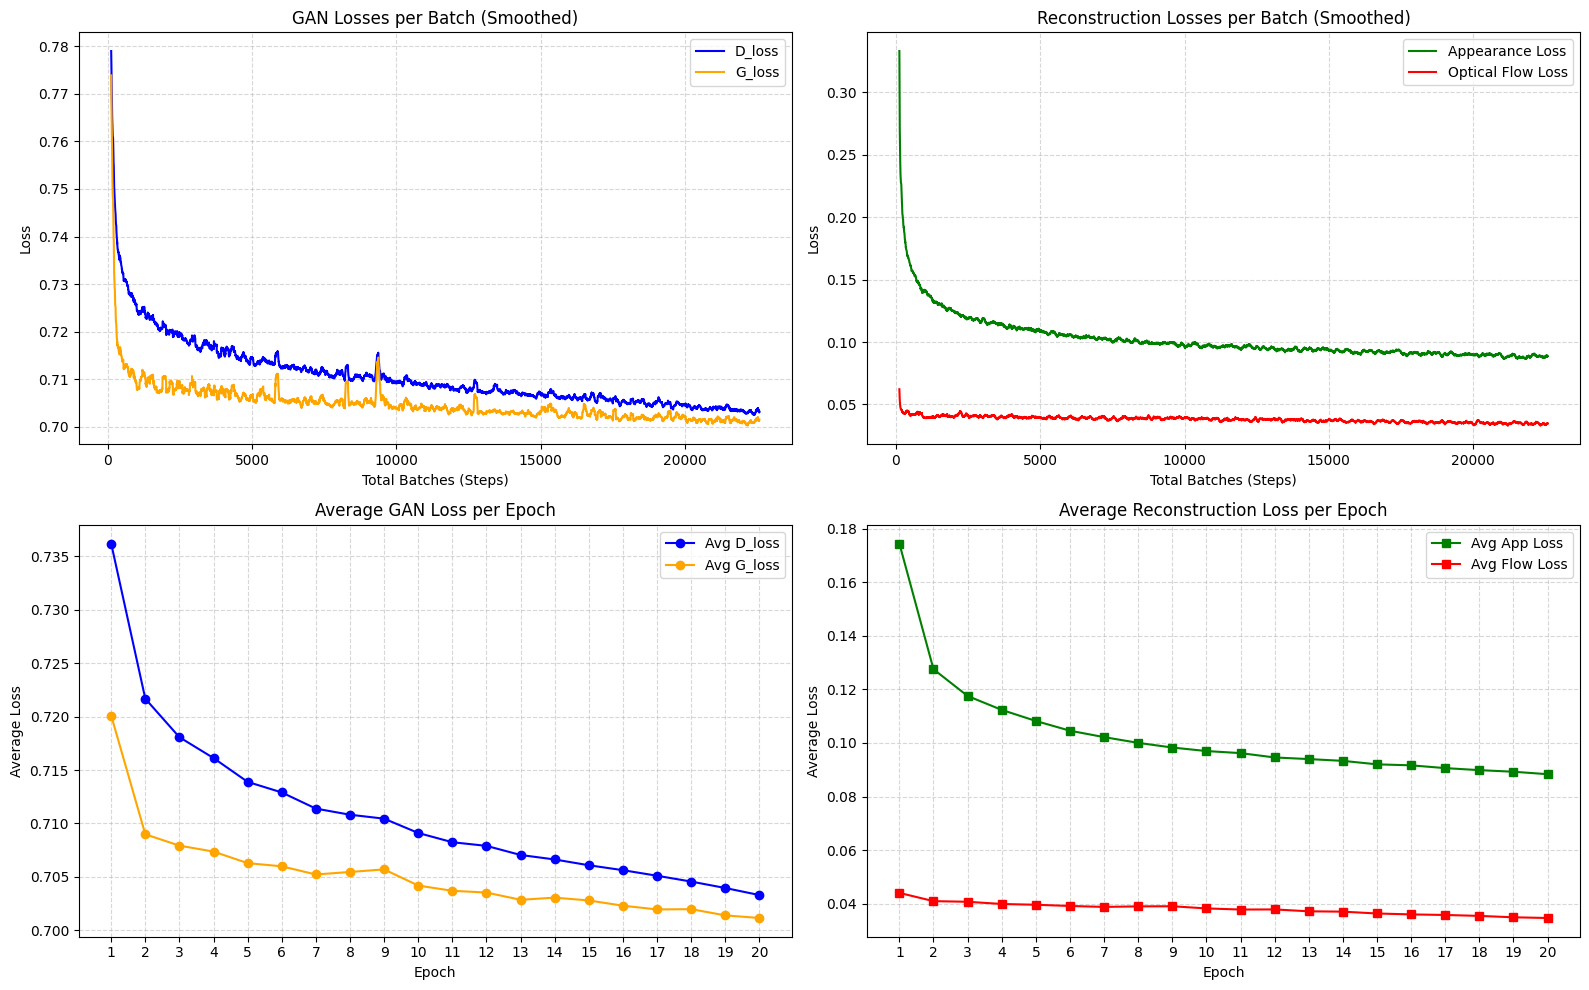

In [1]:
# ==========================================
# CELL 1: Imports and Setup
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Added the 'r' outside the string to fix the Windows \t path bug!
log_file_path = r".\train_results_2\events.out.tfevents.1771950618.cx3-20-5"
# Updated to match your new batch size (1129 iterations per epoch)
STEPS_PER_EPOCH = 1129 

# Load the TensorBoard events file
print(f"Loading {log_file_path}...")
event_acc = EventAccumulator(log_file_path)
event_acc.Reload()

# Check what metrics are actually available in the file
available_tags = event_acc.Tags()['scalars']
print(f"Metrics found in file: {available_tags}")


# ==========================================
# CELL 2: Extract ALL Data & Calculate Averages
# ==========================================
def extract_metric_to_df(tag_name):
    """Extracts TensorBoard events into a Pandas DataFrame."""
    if tag_name not in available_tags:
        print(f"Warning: {tag_name} not found in logs.")
        return pd.DataFrame()
    
    events = event_acc.Scalars(tag_name)
    data = [{'global_batch_step': e.step, tag_name: e.value} for e in events]
    df = pd.DataFrame(data)
    
    # Calculate which epoch each batch belongs to
    df['epoch'] = (df['global_batch_step'] // STEPS_PER_EPOCH) + 1
    return df

# Extract all 4 losses
dfs = [
    extract_metric_to_df('D_loss'),
    extract_metric_to_df('G_loss'),
    extract_metric_to_df('appe_loss'),
    extract_metric_to_df('opt_loss')
]

# Merge them into one big master table
df_all = dfs[0]
for df in dfs[1:]:
    if not df.empty:
        df_all = pd.merge(df_all, df, on=['global_batch_step', 'epoch'], how='outer')

# Sort chronologically just in case
df_all = df_all.sort_values('global_batch_step').reset_index(drop=True)

# Calculate Average Per Epoch for all 4 metrics
epoch_averages = df_all.groupby('epoch')[['D_loss', 'G_loss', 'appe_loss', 'opt_loss']].mean().reset_index()

print("\n=== AVERAGE LOSS PER EPOCH ===")
print(epoch_averages)


# ==========================================
# CELL 3: Plot the Results (2x2 Grid)
# ==========================================
if not df_all.empty:
    plt.figure(figsize=(16, 10))
    # Note: Smoothing the batch data with a rolling window of 50 so it's readable
    smoothing = 50 

    # Plot 1: GAN Losses (Batch Level)
    plt.subplot(2, 2, 1)
    plt.plot(df_all['global_batch_step'], df_all['D_loss'].rolling(smoothing).mean(), label='D_loss', color='blue')
    plt.plot(df_all['global_batch_step'], df_all['G_loss'].rolling(smoothing).mean(), label='G_loss', color='orange')
    plt.title('GAN Losses per Batch (Smoothed)')
    plt.xlabel('Total Batches (Steps)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot 2: Reconstruction Losses (Batch Level)
    plt.subplot(2, 2, 2)
    plt.plot(df_all['global_batch_step'], df_all['appe_loss'].rolling(smoothing).mean(), label='Appearance Loss', color='green')
    plt.plot(df_all['global_batch_step'], df_all['opt_loss'].rolling(smoothing).mean(), label='Optical Flow Loss', color='red')
    plt.title('Reconstruction Losses per Batch (Smoothed)')
    plt.xlabel('Total Batches (Steps)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot 3: GAN Losses (Epoch Averages)
    plt.subplot(2, 2, 3)
    plt.plot(epoch_averages['epoch'], epoch_averages['D_loss'], marker='o', label='Avg D_loss', color='blue')
    plt.plot(epoch_averages['epoch'], epoch_averages['G_loss'], marker='o', label='Avg G_loss', color='orange')
    plt.title('Average GAN Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.xticks(epoch_averages['epoch']) 
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot 4: Reconstruction Losses (Epoch Averages)
    plt.subplot(2, 2, 4)
    plt.plot(epoch_averages['epoch'], epoch_averages['appe_loss'], marker='s', label='Avg App Loss', color='green')
    plt.plot(epoch_averages['epoch'], epoch_averages['opt_loss'], marker='s', label='Avg Flow Loss', color='red')
    plt.title('Average Reconstruction Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.xticks(epoch_averages['epoch']) 
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
else:
    print("Could not plot because data is empty.")

## Anomaly Detection Testing (Enhanced)

Load **non-normal** samples from Dataset_1 (M&M) and Dataset_2 (ACDC),
run them through the trained COMBINED_NOR model, and evaluate
reconstruction quality using the full scoring pipeline from `utils.py`:

- **Appearance** metrics (PSNR, SSIM, MSE) between input and reconstructed frames
- **Optical flow** metrics between real and predicted flow
- **Flow angle** and **magnitude** errors
- **Patch-level** anomaly scoring via `find_max_patch`

> **Model checkpoint**: `training_saver/COMBINED_NOR/COMBINED_NOR/`


In [ ]:
import os, cv2, numpy as np, pandas as pd, SimpleITK as sitk

# =============================================================================
# Helper: load NON-NORMAL (anomalous) frame pairs from both datasets
# =============================================================================
def load_anomalous_samples(
        acdc_testing_dir,
        mm_training_dir,
        mm_csv_path,
        target_size=(128, 192),
        max_subjects_acdc=5,
        max_subjects_mm=5,
        pathologies_mm=None,
        use_ed_es_only=True
):
    """
    Returns
    -------
    images   : np.ndarray (N, H, W, 3)
    flows    : np.ndarray (N, H, W, 3)
    metadata : list[dict] with subject_id, dataset, pathology, z_slice
    """
    def _preprocess(frame, p1, p99, target_size):
        fr = cv2.resize(frame.astype(np.float32),
                        (target_size[1], target_size[0]))
        if (p99 - p1) < 1e-7:
            return np.stack([np.zeros(target_size, np.float32)] * 3, -1)
        fn = np.clip((fr - p1) / (p99 - p1 + 1e-8), 0.0, 1.0)
        return np.stack([fn] * 3, -1)

    all_images, all_flows, all_meta = [], [], []

    # ── ACDC testing set ────────────────────────────────────────────────────
    acdc_patients = sorted([
        d for d in os.listdir(acdc_testing_dir)
        if os.path.isdir(os.path.join(acdc_testing_dir, d))
    ])
    acdc_count = 0
    for p in acdc_patients:
        if max_subjects_acdc is not None and acdc_count >= max_subjects_acdc:
            break
        p_dir    = os.path.join(acdc_testing_dir, p)
        cfg_path = os.path.join(p_dir, 'Info.cfg')
        if not os.path.exists(cfg_path):
            continue
        info = {}
        with open(cfg_path) as f:
            for line in f:
                if ':' in line:
                    k, v = line.split(':', 1)
                    info[k.strip()] = v.strip()
        group = info.get('Group', 'UNK')
        if group == 'NOR':
            continue

        nii_path = os.path.join(p_dir, f'{p}_4d.nii.gz')
        if not os.path.exists(nii_path):
            continue
        try:
            img_arr = sitk.GetArrayFromImage(sitk.ReadImage(nii_path))
        except Exception as e:
            print(f"[ACDC] Load error {p}: {e}"); continue
        if img_arr.ndim != 4:
            continue
        T, Z, _, _ = img_arr.shape
        try:
            ed_idx = int(info.get('ED', 0))
            es_idx = int(info.get('ES', 0))
        except ValueError:
            ed_idx, es_idx = 0, T // 2
        if use_ed_es_only:
            if es_idx >= T or ed_idx >= T:
                continue
            frame_pairs = [(es_idx, ed_idx)]
        else:
            frame_pairs = [(t, t+1) for t in range(T-1)]

        print(f"[ACDC] {p} ({group})  ED={ed_idx}  ES={es_idx}  T={T}  Z={Z}")
        for z in range(Z):
            sl = img_arr[:, z, :, :]
            p1, p99 = np.percentile(sl, 1), np.percentile(sl, 99)
            for (t_in, t_out) in frame_pairs:
                fr_in  = _preprocess(sl[t_in],  p1, p99, target_size)
                fr_out = _preprocess(sl[t_out], p1, p99, target_size)
                g_in  = (fr_in[:, :, 0] * 255).astype(np.uint8)
                g_out = (fr_out[:, :, 0] * 255).astype(np.uint8)
                try:
                    flow = cv2.calcOpticalFlowFarneback(
                               g_in, g_out, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                except Exception:
                    continue
                mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                all_images.append(fr_in)
                all_flows.append(np.dstack((flow, mag)))
                all_meta.append({'subject_id': p, 'dataset': 'ACDC',
                                  'pathology': group, 'z_slice': z})
        acdc_count += 1

    # ── M&M training set (non-NOR) ──────────────────────────────────────────
    df = pd.read_csv(mm_csv_path)
    df_anom = df[df['Pathology'].isin(pathologies_mm)] if pathologies_mm else df[df['Pathology'] != 'NOR']
    subject_info = {
        row['External code']: (int(row['ED']), int(row['ES']), row['Pathology'])
        for _, row in df_anom.iterrows()
    }
    print(f"[M&M] Found {len(subject_info)} non-NOR subjects in CSV.")

    sa_files = sorted([f for f in os.listdir(mm_training_dir)
                       if f.endswith('_sa.nii.gz')
                       and not f.endswith('_sa_gt.nii.gz')])
    mm_count = 0
    for fname in sa_files:
        if max_subjects_mm is not None and mm_count >= max_subjects_mm:
            break
        sid = fname.replace('_sa.nii.gz', '')
        if sid not in subject_info:
            continue
        ed_idx, es_idx, pathology = subject_info[sid]
        nii_path = os.path.join(mm_training_dir, fname)
        try:
            img_arr = sitk.GetArrayFromImage(sitk.ReadImage(nii_path))
        except Exception as e:
            print(f"[M&M] Load error {sid}: {e}"); continue
        if img_arr.ndim != 4:
            continue
        T, Z, _, _ = img_arr.shape
        if use_ed_es_only:
            if es_idx >= T or ed_idx >= T:
                continue
            frame_pairs = [(es_idx, ed_idx)]
        else:
            frame_pairs = [(t, t+1) for t in range(T-1)]
        print(f"[M&M]  {sid} ({pathology})  ED={ed_idx}  ES={es_idx}  T={T}  Z={Z}")
        for z in range(Z):
            sl = img_arr[:, z, :, :]
            p1, p99 = np.percentile(sl, 1), np.percentile(sl, 99)
            for (t_in, t_out) in frame_pairs:
                fr_in  = _preprocess(sl[t_in],  p1, p99, target_size)
                fr_out = _preprocess(sl[t_out], p1, p99, target_size)
                g_in  = (fr_in[:, :, 0] * 255).astype(np.uint8)
                g_out = (fr_out[:, :, 0] * 255).astype(np.uint8)
                try:
                    flow = cv2.calcOpticalFlowFarneback(
                               g_in, g_out, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                except Exception:
                    continue
                mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                all_images.append(fr_in)
                all_flows.append(np.dstack((flow, mag)))
                all_meta.append({'subject_id': sid, 'dataset': 'MM',
                                  'pathology': pathology, 'z_slice': z})
        mm_count += 1

    print(f"\nTotal anomalous samples loaded: {len(all_images)}")
    return (np.array(all_images, dtype=np.float32),
            np.array(all_flows, dtype=np.float32),
            all_meta)


# =============================================================================
# Load samples
# =============================================================================
acdc_testing_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2/database/testing"
mm_training_dir  = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/Testing"
mm_csv_path      = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"

test_images, test_flows, test_meta = load_anomalous_samples(
    acdc_testing_dir  = acdc_testing_dir,
    mm_training_dir   = mm_training_dir,
    mm_csv_path       = mm_csv_path,
    max_subjects_acdc = 20,     # increase or set None for all
    max_subjects_mm   = 20,
    pathologies_mm    = None,  # None = all non-NOR; e.g. ['DCM', 'HCM']
    use_ed_es_only    = True
)

print(f"test_images : {test_images.shape}")
print(f"test_flows  : {test_flows.shape}")
print(f"Unique pathologies: { {m['pathology'] for m in test_meta} }")


[ACDC] patient101 (DCM)  ED=1  ES=14  T=30  Z=10
[ACDC] patient103 (MINF)  ED=1  ES=11  T=30  Z=9
[ACDC] patient104 (HCM)  ED=1  ES=11  T=30  Z=9
[ACDC] patient105 (HCM)  ED=1  ES=10  T=30  Z=10
[ACDC] patient106 (DCM)  ED=1  ES=13  T=30  Z=9
[ACDC] patient108 (HCM)  ED=1  ES=9  T=30  Z=10
[ACDC] patient109 (RV)  ED=1  ES=10  T=30  Z=8
[ACDC] patient111 (HCM)  ED=1  ES=7  T=15  Z=6
[ACDC] patient112 (MINF)  ED=1  ES=12  T=30  Z=10
[ACDC] patient113 (DCM)  ED=1  ES=8  T=15  Z=10
[M&M] Found 256 non-NOR subjects in CSV.
[M&M]  A1K2P5 (DCM)  ED=33  ES=11  T=34  Z=14
[M&M]  A2H5K9 (HHD)  ED=29  ES=8  T=30  Z=10
[M&M]  A2L1N6 (DCM)  ED=0  ES=12  T=25  Z=13
[M&M]  A3H5R1 (HHD)  ED=24  ES=6  T=25  Z=12
[M&M]  A3P9V7 (HHD)  ED=27  ES=13  T=28  Z=12
[M&M]  A4A8V9 (DCM)  ED=0  ES=10  T=30  Z=12
[M&M]  A4B9O6 (Other)  ED=0  ES=11  T=34  Z=11
[M&M]  A4K8R4 (HCM)  ED=24  ES=11  T=28  Z=12
[M&M]  A4R4T0 (Other)  ED=21  ES=8  T=22  Z=10
[M&M]  A5D0G0 (HCM)  ED=0  ES=10  T=30  Z=10

Total anomalous sa

In [32]:
import tensorflow as tf
import GAN_tf

# =============================================================================
# Run inference using the trained COMBINED_NOR model
# Pattern follows GAN_tf.test_Unet_naive_with_batch_norm (updated version)
# =============================================================================

MODEL_DIR   = r'./training_saver/COMBINED_NOR/COMBINED_NOR'
MODEL_EPOCH = 20
BATCH_SIZE  = 8
H, W        = 128, 192

# ── Build graph (reset first, matching GAN_tf.test_Unet_naive_with_batch_norm) ─
tf.compat.v1.reset_default_graph()

plh_frame_true   = tf.compat.v1.placeholder(tf.float32, shape=[None, H, W, 3])
plh_is_training  = tf.compat.v1.placeholder(tf.bool)
plh_dropout_prob = tf.compat.v1.placeholder_with_default(1.0, shape=())

# Scale [0,1] → [-1,1] inside the graph (matching training & test functions)
scaled_frame_true = (plh_frame_true / 0.5) - 1.0

output_opt, output_appe = GAN_tf.Generator(
    scaled_frame_true, plh_is_training, plh_dropout_prob)

saver = tf.compat.v1.train.Saver()

# ── Inference loop ───────────────────────────────────────────────────────────
n = len(test_images)
recon_images = np.zeros_like(test_images)   # reconstructed frames  [0,1]
recon_flows  = np.zeros_like(test_flows)    # reconstructed flows

checkpoint_path = f'{MODEL_DIR}/model_ckpt_{MODEL_EPOCH}.ckpt'
print(f"Loading checkpoint: {checkpoint_path}")

batch_indices = np.array_split(np.arange(n), int(np.ceil(n / BATCH_SIZE)))

with tf.compat.v1.Session() as sess:
    saver.restore(sess, checkpoint_path)
    print(f"Model restored.  Running inference on {n} samples ...")
    for idx_batch in batch_indices:
        # Feed RAW [0,1] images — graph scales them automatically
        out_appe, out_opt = sess.run(
            [output_appe, output_opt],
            feed_dict={plh_frame_true:  test_images[idx_batch],
                       plh_is_training: False,
                       plh_dropout_prob: 1.0})
        # Scale generator appearance output back from [-1,1] to [0,1]
        recon_images[idx_batch] = 0.5 * (out_appe + 1.0)
        recon_flows[idx_batch]  = out_opt

print("Inference complete.")
print(f"recon_images range: [{recon_images.min():.3f}, {recon_images.max():.3f}]")
print(f"recon_flows  range: [{recon_flows.min():.3f}, {recon_flows.max():.3f}]")


c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:145: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  d = tf.layers.batch_normalization(d, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:153: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  u = tf.layers.batch_normalization(u, training=training)


Loading checkpoint: ./training_saver/COMBINED_NOR/COMBINED_NOR/model_ckpt_20.ckpt
INFO:tensorflow:Restoring parameters from ./training_saver/COMBINED_NOR/COMBINED_NOR/model_ckpt_20.ckpt
Model restored.  Running inference on 207 samples ...
Inference complete.
recon_images range: [-0.041, 1.115]
recon_flows  range: [-1.088, 1.363]


In [33]:
from utils import calc_anomaly_score_one_frame, find_max_patch
from skimage.metrics import structural_similarity as ssim

# =============================================================================
# Compute anomaly scores using the full utils.py pipeline
# =============================================================================

n_samples = len(test_images)

# calc_anomaly_score_one_frame returns a (4, 10) matrix per sample:
#   rows: [appearance, flow, angle, magnitude]
#   cols: [PSNR_X, PSNR_inv, PSNR, SSIM, MSE, maxSE, std, MSE_1c, maxSE_1c, std_1c]
score_names = ['PSNR_X','PSNR_inv','PSNR','SSIM','MSE','maxSE','std',
               'MSE_1c','maxSE_1c','std_1c']
channel_names = ['Appearance', 'Flow', 'Angle', 'Magnitude']

all_scores = np.zeros((n_samples, 4, 10))
all_patch_scores = np.zeros((n_samples, 8))  # from find_max_patch

for i in range(n_samples):
    # Full scoring via utils.calc_anomaly_score_one_frame
    all_scores[i] = calc_anomaly_score_one_frame(
        test_images[i], recon_images[i],
        test_flows[i],  recon_flows[i]
    )

    # Patch-level scoring via utils.find_max_patch
    diff_flow = np.sum((test_flows[i] - recon_flows[i])**2, axis=-1)
    diff_appe = np.sum((test_images[i] - recon_images[i])**2, axis=-1)
    all_patch_scores[i] = find_max_patch(diff_flow, diff_appe, size=16, step=4)

print("=" * 70)
print("ANOMALY SCORES SUMMARY")
print("=" * 70)
for ch_idx, ch_name in enumerate(channel_names):
    print(f"\n{ch_name}:")
    for sc_idx, sc_name in enumerate(score_names):
        vals = all_scores[:, ch_idx, sc_idx]
        print(f"  {sc_name:12s}  min={vals.min():.4f}  mean={vals.mean():.4f}  max={vals.max():.4f}")

# ── Attach key scores to metadata ───────────────────────────────────────────
for i, m in enumerate(test_meta):
    m['appe_PSNR']  = float(all_scores[i, 0, 2])   # Appearance PSNR
    m['appe_SSIM']  = float(all_scores[i, 0, 3])   # Appearance SSIM
    m['appe_MSE']   = float(all_scores[i, 0, 4])   # Appearance MSE
    m['flow_PSNR']  = float(all_scores[i, 1, 2])   # Flow PSNR
    m['flow_MSE']   = float(all_scores[i, 1, 4])   # Flow MSE
    m['angle_MSE']  = float(all_scores[i, 2, 4])   # Angle MSE
    m['mag_MSE']    = float(all_scores[i, 3, 4])   # Magnitude MSE
    m['patch_mean_flow'] = float(all_patch_scores[i, 0])
    m['patch_mean_appe'] = float(all_patch_scores[i, 3])

print("\nScoring complete.  Key scores attached to test_meta[].")


ANOMALY SCORES SUMMARY

Appearance:
  PSNR_X        min=25.0103  mean=28.2207  max=32.1471
  PSNR_inv      min=0.0006  mean=0.0017  max=0.0037
  PSNR          min=24.6760  mean=28.0458  max=32.1130
  SSIM          min=0.5570  mean=0.8275  max=0.9344
  MSE           min=0.0006  mean=0.0016  max=0.0034
  maxSE         min=0.0251  mean=0.1385  max=0.6549
  std           min=0.0010  mean=0.0040  max=0.0110
  MSE_1c        min=0.0018  mean=0.0049  max=0.0102
  maxSE_1c      min=0.0752  mean=0.4155  max=1.9646
  std_1c        min=0.0031  mean=0.0120  max=0.0329

Flow:
  PSNR_X        min=-13.0500  mean=-0.9352  max=17.4303
  PSNR_inv      min=0.0001  mean=0.0829  max=1.5347
  PSNR          min=6.5056  mean=17.9585  max=34.3439
  SSIM          min=0.3408  mean=0.5997  max=0.8026
  MSE           min=0.0036  mean=0.2805  max=2.2067
  maxSE         min=0.3910  mean=21.2352  max=113.9449
  std           min=0.0120  mean=1.3090  max=8.7838
  MSE_1c        min=0.0109  mean=0.8416  max=6.6200
  maxS

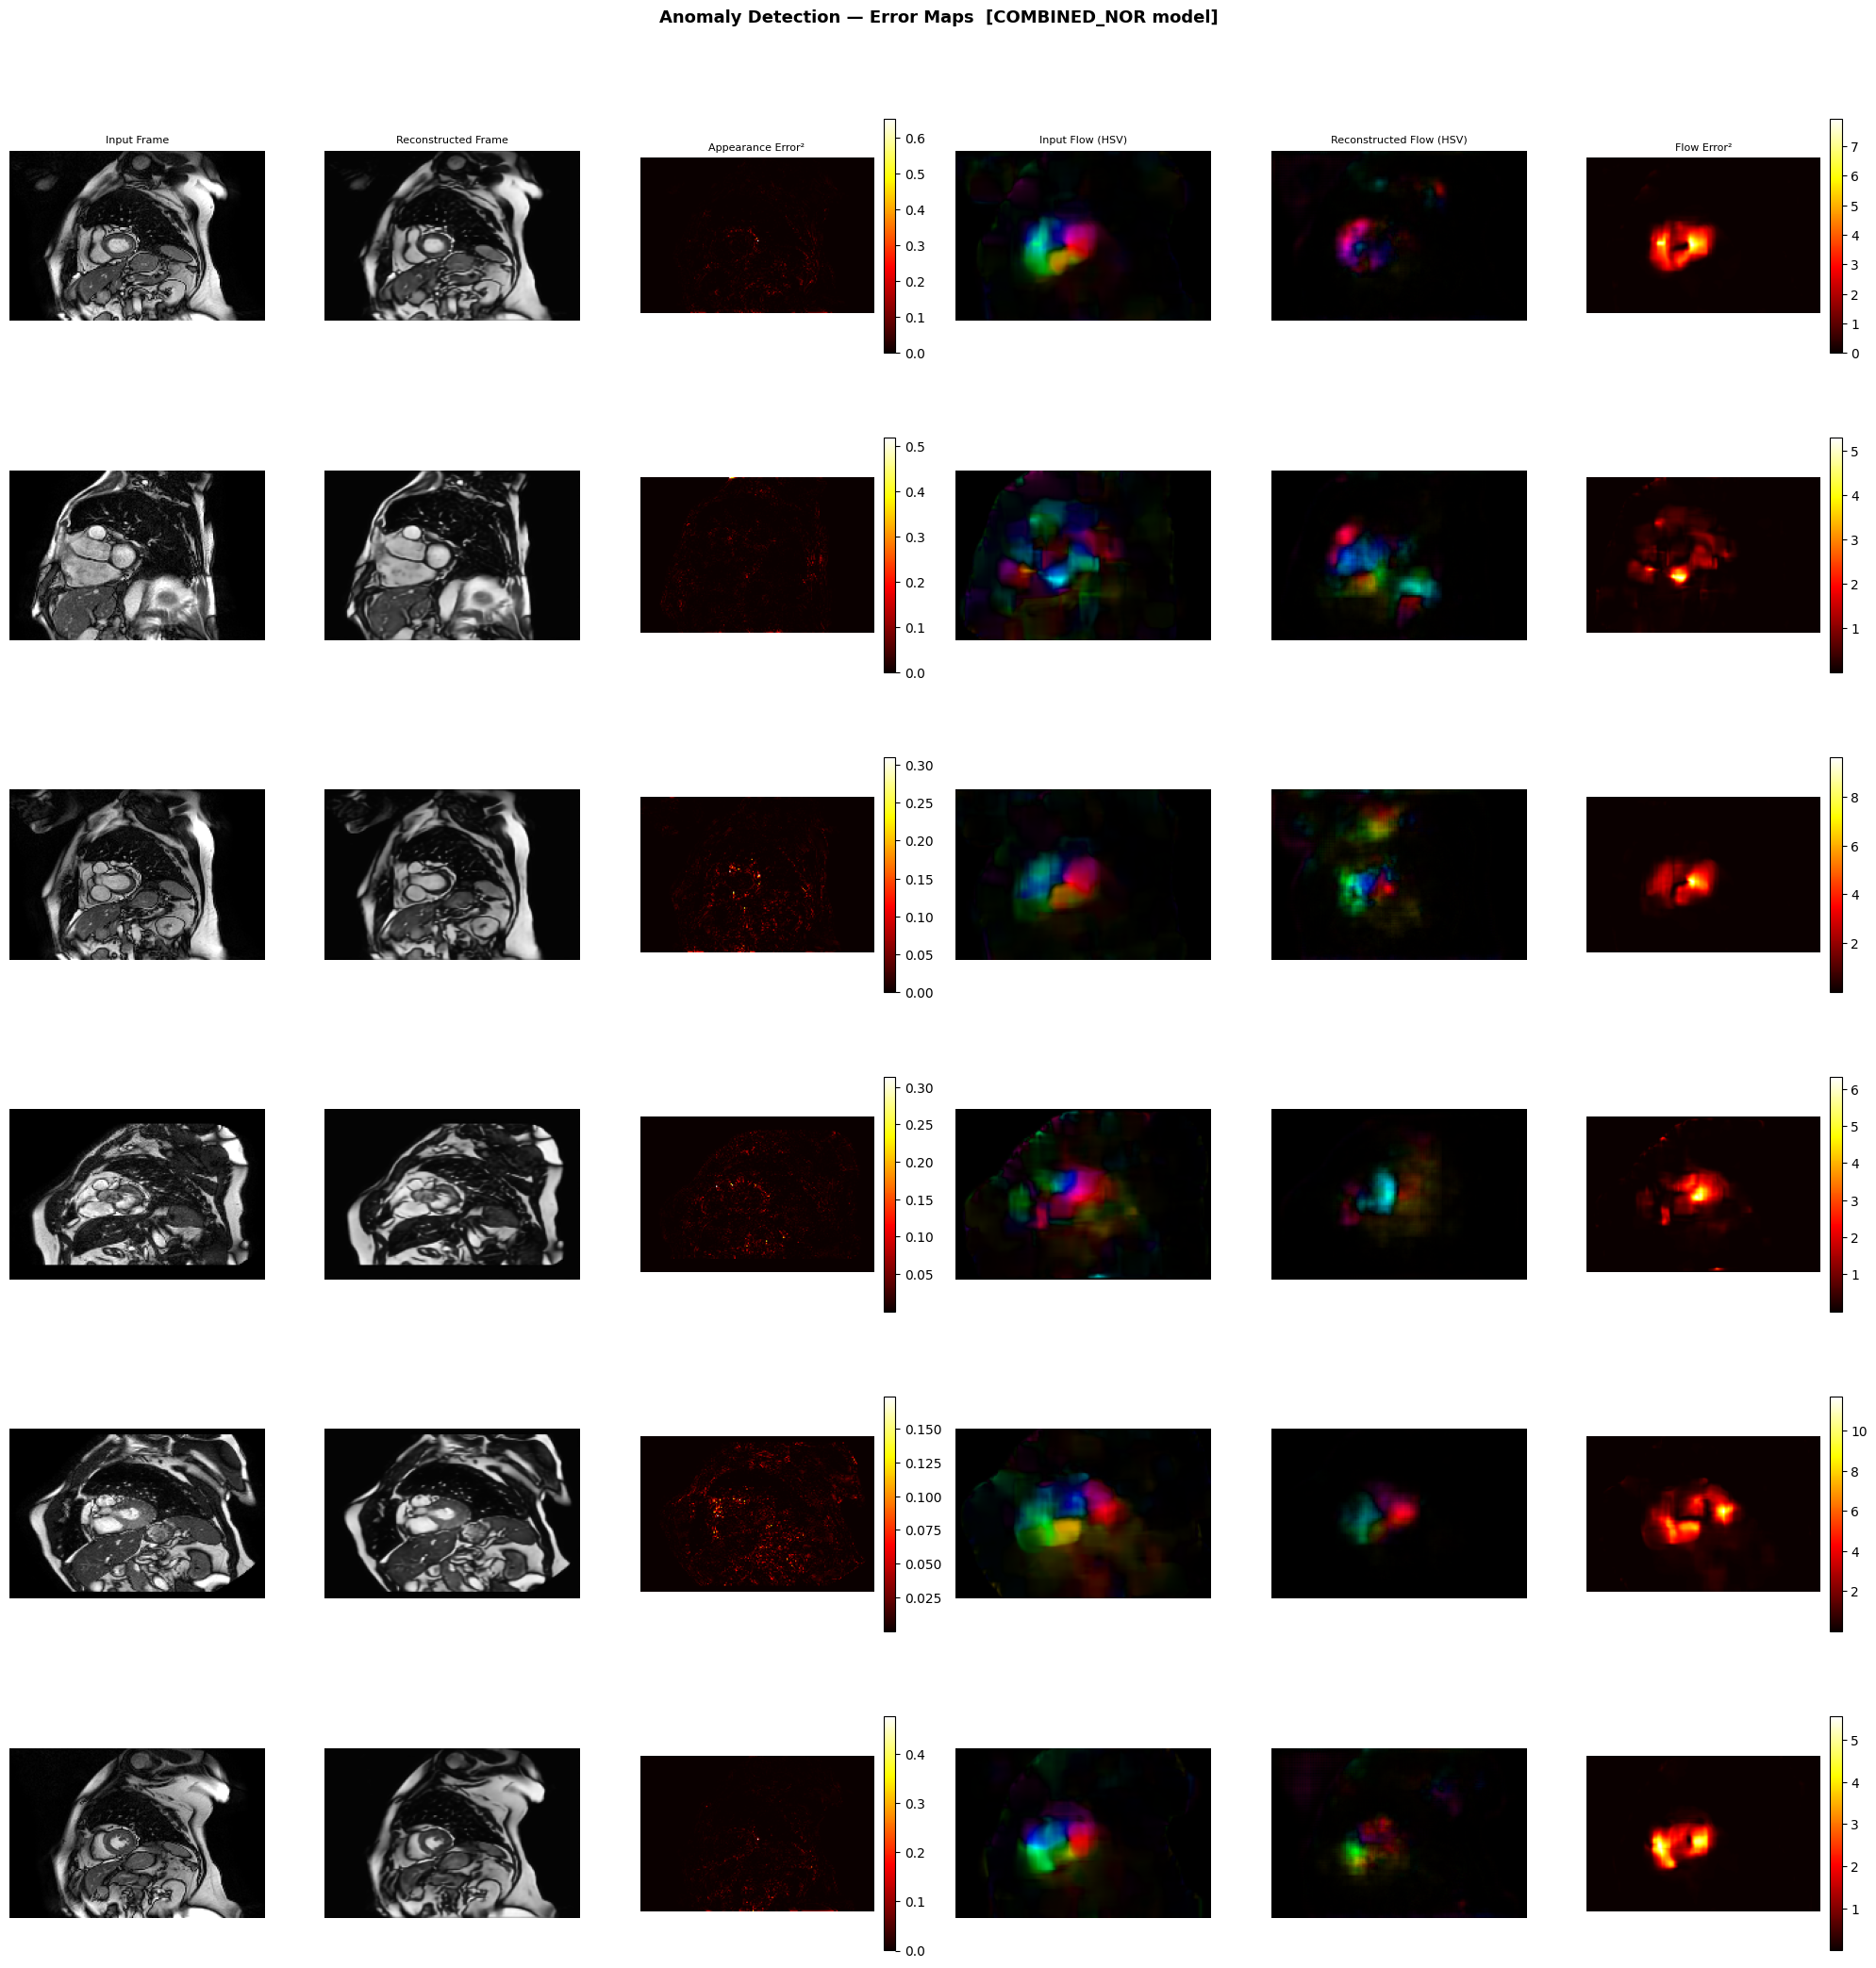


 Pathology | Count |  Appe PSNR |  Appe SSIM |   Appe MSE |   Flow MSE |  Angle MSE
-------------------------------------------------------------------------------------
       DCM |    68 |      28.66 |     0.8334 |   0.001396 |   0.292032 |   3.053572
       HCM |    57 |      27.41 |     0.8352 |   0.001863 |   0.328256 |   2.902682
       HHD |    34 |      28.88 |     0.7856 |   0.001395 |   0.174098 |   3.064749
      MINF |    19 |      27.35 |     0.8965 |   0.001851 |   0.414231 |   3.072902
     Other |    21 |      26.53 |     0.7641 |   0.002254 |   0.118711 |   3.053337
        RV |     8 |      29.45 |     0.9033 |   0.001144 |   0.402685 |   3.442266


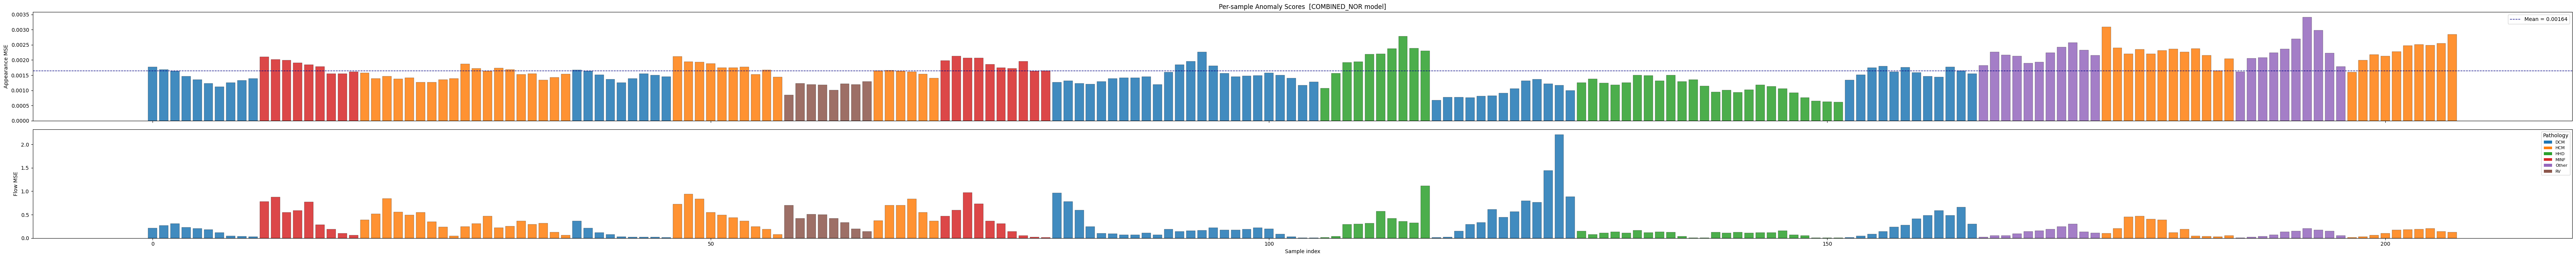

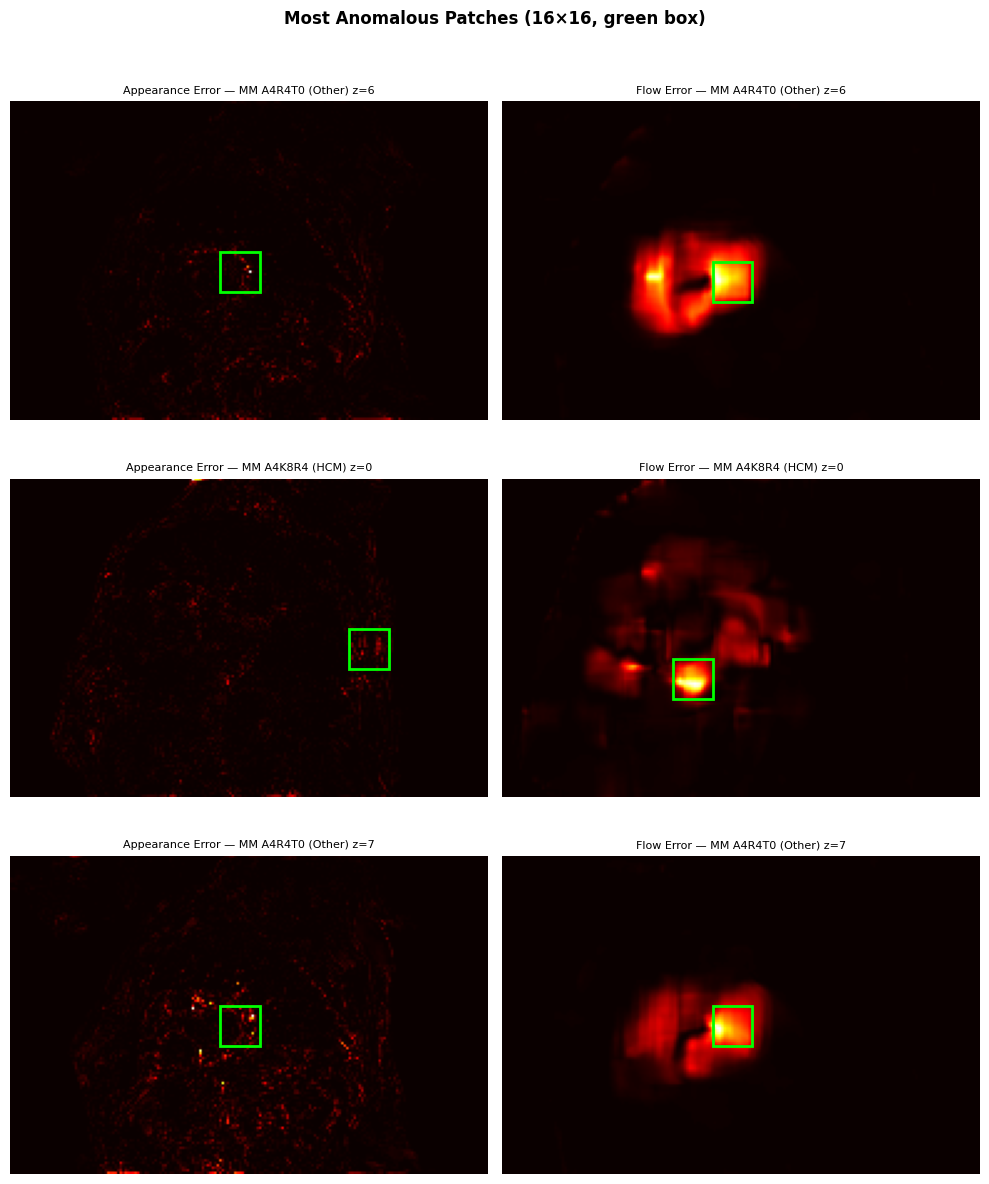


Top-10 most anomalous samples (by Appearance MSE):
Rank  Dataset       Subject    Path    z     PSNR     SSIM         MSE    Flow MSE
--------------------------------------------------------------------------------
   1      MM        A4R4T0   Other    6    24.68   0.7872    0.003407    0.204552
   2      MM        A4K8R4     HCM    0    25.10   0.7394    0.003091    0.100684
   3      MM        A4R4T0   Other    7    25.26   0.7843    0.002980    0.170525
   4      MM        A5D0G0     HCM    9    25.45   0.7262    0.002848    0.128979
   5      MM        A2H5K9     HHD    7    25.55   0.7908    0.002786    0.353424
   6      MM        A4R4T0   Other    5    25.70   0.7851    0.002689    0.151155
   7      MM        A4B9O6   Other    8    25.90   0.8028    0.002570    0.298843
   8      MM        A5D0G0     HCM    8    25.94   0.7255    0.002545    0.142807
   9      MM        A5D0G0     HCM    6    26.00   0.7238    0.002514    0.193059
  10      MM        A5D0G0     HCM    7    26.

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, Patch

# =============================================================================
# 1.  Error-map grid (6 rows): matches utils.plot_error_map layout
# =============================================================================

def flow_to_color(flow_3ch):
    """Convert [dx, dy, mag] to HSV-based RGB for display."""
    dx, dy = flow_3ch[..., 0], flow_3ch[..., 1]
    mag, ang = cv2.cartToPolar(dx, dy)
    hsv = np.zeros((*dx.shape, 3), dtype=np.float32)
    hsv[..., 0] = ang / (2 * np.pi)
    hsv[..., 1] = 1.0
    hsv[..., 2] = mag / (np.max(mag) + 1e-8)
    return mcolors.hsv_to_rgb(hsv)

N_SHOW   = min(6, len(test_images))
# Sort by appearance MSE (descending) to show most anomalous first
appe_mse = all_scores[:, 0, 4]  # Appearance MSE column
sorted_idx = np.argsort(appe_mse)[::-1][:N_SHOW]

row_titles = ['Input Frame', 'Reconstructed Frame', 'Appearance Error²',
              'Input Flow (HSV)', 'Reconstructed Flow (HSV)', 'Flow Error²']

fig, axes = plt.subplots(N_SHOW, 6, figsize=(20, 3.5 * N_SHOW))
if N_SHOW == 1:
    axes = axes[np.newaxis, :]

for row, i in enumerate(sorted_idx):
    m = test_meta[i]
    label = (f"{m['dataset']} {m['subject_id']} ({m['pathology']}) "
             f"z={m['z_slice']}  PSNR={m['appe_PSNR']:.1f}  "
             f"SSIM={m['appe_SSIM']:.3f}  MSE={m['appe_MSE']:.5f}")

    imgs_row = [
        test_images[i],                                      # input frame
        recon_images[i],                                     # reconstructed frame
        np.mean((test_images[i] - recon_images[i])**2, -1),  # appearance error
        flow_to_color(test_flows[i]),                         # input flow HSV
        flow_to_color(recon_flows[i]),                        # recon flow HSV
        np.mean((test_flows[i] - recon_flows[i])**2, -1),    # flow error
    ]

    for col in range(6):
        ax = axes[row, col]
        img = imgs_row[col]
        if col in (0, 1):       # grayscale frames
            ax.imshow(np.clip(img, 0, 1))
        elif col in (3, 4):     # HSV flow images
            ax.imshow(img)
        else:                   # error maps
            im = ax.imshow(img, cmap='hot')
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        if row == 0:
            ax.set_title(row_titles[col], fontsize=8)
        ax.axis('off')

    # Label on leftmost axis
    axes[row, 0].set_ylabel(label, fontsize=6.5, rotation=0, labelpad=180, va='center')

plt.suptitle('Anomaly Detection — Error Maps  [COMBINED_NOR model]',
             fontweight='bold', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# =============================================================================
# 2.  Per-pathology summary table
# =============================================================================
pathologies = sorted({m['pathology'] for m in test_meta})
print("\n" + "=" * 85)
print(f"{'Pathology':>10s} | {'Count':>5s} | {'Appe PSNR':>10s} | {'Appe SSIM':>10s} | "
      f"{'Appe MSE':>10s} | {'Flow MSE':>10s} | {'Angle MSE':>10s}")
print("-" * 85)
for path in pathologies:
    idx = [i for i, m in enumerate(test_meta) if m['pathology'] == path]
    sc  = all_scores[idx]
    print(f"{path:>10s} | {len(idx):5d} | "
          f"{sc[:, 0, 2].mean():10.2f} | {sc[:, 0, 3].mean():10.4f} | "
          f"{sc[:, 0, 4].mean():10.6f} | {sc[:, 1, 4].mean():10.6f} | "
          f"{sc[:, 2, 4].mean():10.6f}")
print("=" * 85)

# =============================================================================
# 3.  Bar chart: per-sample anomaly score by pathology
# =============================================================================
cmap_p     = plt.get_cmap('tab10')
p_to_color = {p: cmap_p(i) for i, p in enumerate(pathologies)}

fig2, (ax_a, ax_f) = plt.subplots(2, 1, figsize=(max(10, n_samples // 3), 7),
                                   sharex=True)

x = np.arange(n_samples)
colors = [p_to_color[m['pathology']] for m in test_meta]

# Appearance MSE
ax_a.bar(x, all_scores[:, 0, 4], color=colors, alpha=0.85, edgecolor='k', lw=0.3)
ax_a.set_ylabel('Appearance MSE')
ax_a.set_title('Per-sample Anomaly Scores  [COMBINED_NOR model]')
ax_a.axhline(all_scores[:, 0, 4].mean(), ls='--', color='navy', lw=1,
             label=f'Mean = {all_scores[:, 0, 4].mean():.5f}')
ax_a.legend()

# Flow MSE
ax_f.bar(x, all_scores[:, 1, 4], color=colors, alpha=0.85, edgecolor='k', lw=0.3)
ax_f.set_ylabel('Flow MSE')
ax_f.set_xlabel('Sample index')

legend_elems = [Patch(facecolor=p_to_color[p], label=p) for p in pathologies]
ax_f.legend(handles=legend_elems, title='Pathology', fontsize=8)
plt.tight_layout()
plt.show()

# =============================================================================
# 4.  Max-patch overlay on top-3 most anomalous samples
# =============================================================================
N_PATCH = min(3, N_SHOW)
fig3, axes3 = plt.subplots(N_PATCH, 2, figsize=(10, 4 * N_PATCH))
if N_PATCH == 1:
    axes3 = axes3[np.newaxis, :]

for row, i in enumerate(sorted_idx[:N_PATCH]):
    m = test_meta[i]
    diff_appe_map = np.sum((test_images[i] - recon_images[i])**2, axis=-1)
    diff_flow_map = np.sum((test_flows[i] - recon_flows[i])**2, axis=-1)

    # Re-run find_max_patch to get patch positions
    size, step = 16, 4
    best_mean, best_pos = 0, None
    for yi in range(0, diff_flow_map.shape[0] - size, step):
        for xi in range(0, diff_flow_map.shape[1] - size, step):
            curr = np.mean(diff_flow_map[yi:yi+size, xi:xi+size])
            if curr > best_mean:
                best_mean, best_pos = curr, (xi, yi)

    best_mean_a, best_pos_a = 0, None
    for yi in range(0, diff_appe_map.shape[0] - size, step):
        for xi in range(0, diff_appe_map.shape[1] - size, step):
            curr = np.mean(diff_appe_map[yi:yi+size, xi:xi+size])
            if curr > best_mean_a:
                best_mean_a, best_pos_a = curr, (xi, yi)

    title = f"{m['dataset']} {m['subject_id']} ({m['pathology']}) z={m['z_slice']}"

    # Appearance error + patch
    ax_a = axes3[row, 0]
    ax_a.imshow(diff_appe_map, cmap='hot')
    if best_pos_a:
        rect = Rectangle(best_pos_a, size, size, lw=2, edgecolor='lime', facecolor='none')
        ax_a.add_patch(rect)
    ax_a.set_title(f'Appearance Error — {title}', fontsize=8)
    ax_a.axis('off')

    # Flow error + patch
    ax_f = axes3[row, 1]
    ax_f.imshow(diff_flow_map, cmap='hot')
    if best_pos:
        rect = Rectangle(best_pos, size, size, lw=2, edgecolor='lime', facecolor='none')
        ax_f.add_patch(rect)
    ax_f.set_title(f'Flow Error — {title}', fontsize=8)
    ax_f.axis('off')

plt.suptitle('Most Anomalous Patches (16×16, green box)',
             fontweight='bold', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

# =============================================================================
# 5.  Top-10 most anomalous samples
# =============================================================================
top_n = min(10, n_samples)
top_idx = np.argsort(all_scores[:, 0, 4])[::-1][:top_n]
print(f"\nTop-{top_n} most anomalous samples (by Appearance MSE):")
print(f"{'Rank':>4s}  {'Dataset':>6s}  {'Subject':>12s}  {'Path':>6s}  "
      f"{'z':>3s}  {'PSNR':>7s}  {'SSIM':>7s}  {'MSE':>10s}  {'Flow MSE':>10s}")
print("-" * 80)
for rank, i in enumerate(top_idx, 1):
    m = test_meta[i]
    print(f"{rank:4d}  {m['dataset']:>6s}  {m['subject_id']:>12s}  "
          f"{m['pathology']:>6s}  {m['z_slice']:3d}  "
          f"{m['appe_PSNR']:7.2f}  {m['appe_SSIM']:7.4f}  "
          f"{m['appe_MSE']:10.6f}  {m['flow_MSE']:10.6f}")


## Normal Patient Reconstruction Error (Baseline)

Compute reconstruction error for **normal (NOR)** patients from both datasets
to establish a baseline. Comparing these scores against the anomalous scores
(cells 19–23) shows how much worse the model reconstructs pathological samples.

| Dataset | Source directory | Selection |
|---------|-----------------|-----------|
| ACDC    | `database/testing/` | `Group == NOR` in Info.cfg |
| M&M     | `Training/`         | `Pathology == NOR` in CSV |


In [39]:
import os, cv2, numpy as np, pandas as pd, SimpleITK as sitk

# =============================================================================
# Load NORMAL test samples from both datasets
# =============================================================================
def load_normal_samples(
        acdc_testing_dir,
        mm_training_dir,
        mm_csv_path,
        target_size=(128, 192),
        max_subjects_acdc=5,
        max_subjects_mm=5,
        use_ed_es_only=True
):
    def _preprocess(frame, p1, p99, target_size):
        fr = cv2.resize(frame.astype(np.float32),
                        (target_size[1], target_size[0]))
        if (p99 - p1) < 1e-7:
            return np.stack([np.zeros(target_size, np.float32)] * 3, -1)
        fn = np.clip((fr - p1) / (p99 - p1 + 1e-8), 0.0, 1.0)
        return np.stack([fn] * 3, -1)

    all_images, all_flows, all_meta = [], [], []

    # ── ACDC testing set — NOR only ─────────────────────────────────────────
    acdc_patients = sorted([
        d for d in os.listdir(acdc_testing_dir)
        if os.path.isdir(os.path.join(acdc_testing_dir, d))
    ])
    acdc_count = 0
    for p in acdc_patients:
        if max_subjects_acdc is not None and acdc_count >= max_subjects_acdc:
            break
        p_dir    = os.path.join(acdc_testing_dir, p)
        cfg_path = os.path.join(p_dir, 'Info.cfg')
        if not os.path.exists(cfg_path):
            continue
        info = {}
        with open(cfg_path) as f:
            for line in f:
                if ':' in line:
                    k, v = line.split(':', 1)
                    info[k.strip()] = v.strip()
        group = info.get('Group', 'UNK')
        if group != 'NOR':          # ← only NOR
            continue

        nii_path = os.path.join(p_dir, f'{p}_4d.nii.gz')
        if not os.path.exists(nii_path):
            continue
        try:
            img_arr = sitk.GetArrayFromImage(sitk.ReadImage(nii_path))
        except Exception as e:
            print(f"[ACDC] Load error {p}: {e}"); continue
        if img_arr.ndim != 4:
            continue
        T, Z, _, _ = img_arr.shape
        try:
            ed_idx = int(info.get('ED', 0))
            es_idx = int(info.get('ES', 0))
        except ValueError:
            ed_idx, es_idx = 0, T // 2
        if use_ed_es_only:
            if es_idx >= T or ed_idx >= T:
                continue
            frame_pairs = [(es_idx, ed_idx)]
        else:
            frame_pairs = [(t, t+1) for t in range(T-1)]

        print(f"[ACDC-NOR] {p}  ED={ed_idx}  ES={es_idx}  T={T}  Z={Z}")
        for z in range(Z):
            sl = img_arr[:, z, :, :]
            p1, p99 = np.percentile(sl, 1), np.percentile(sl, 99)
            for (t_in, t_out) in frame_pairs:
                fr_in  = _preprocess(sl[t_in],  p1, p99, target_size)
                fr_out = _preprocess(sl[t_out], p1, p99, target_size)
                g_in  = (fr_in[:, :, 0] * 255).astype(np.uint8)
                g_out = (fr_out[:, :, 0] * 255).astype(np.uint8)
                try:
                    flow = cv2.calcOpticalFlowFarneback(
                               g_in, g_out, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                except Exception:
                    continue
                mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                all_images.append(fr_in)
                all_flows.append(np.dstack((flow, mag)))
                all_meta.append({'subject_id': p, 'dataset': 'ACDC',
                                  'pathology': 'NOR', 'z_slice': z})
        acdc_count += 1

    # ── M&M training set — NOR only ─────────────────────────────────────────
    df = pd.read_csv(mm_csv_path)
    df_nor = df[df['Pathology'] == 'NOR']
    subject_info = {
        row['External code']: (int(row['ED']), int(row['ES']))
        for _, row in df_nor.iterrows()
    }
    print(f"[M&M] Found {len(subject_info)} NOR subjects in CSV.")

    sa_files = sorted([f for f in os.listdir(mm_training_dir)
                       if f.endswith('_sa.nii.gz')
                       and not f.endswith('_sa_gt.nii.gz')])
    mm_count = 0
    for fname in sa_files:
        if max_subjects_mm is not None and mm_count >= max_subjects_mm:
            break
        sid = fname.replace('_sa.nii.gz', '')
        if sid not in subject_info:
            continue
        ed_idx, es_idx = subject_info[sid]
        nii_path = os.path.join(mm_training_dir, fname)
        try:
            img_arr = sitk.GetArrayFromImage(sitk.ReadImage(nii_path))
        except Exception as e:
            print(f"[M&M] Load error {sid}: {e}"); continue
        if img_arr.ndim != 4:
            continue
        T, Z, _, _ = img_arr.shape
        if use_ed_es_only:
            if es_idx >= T or ed_idx >= T:
                continue
            frame_pairs = [(es_idx, ed_idx)]
        else:
            frame_pairs = [(t, t+1) for t in range(T-1)]
        print(f"[M&M-NOR]  {sid}  ED={ed_idx}  ES={es_idx}  T={T}  Z={Z}")
        for z in range(Z):
            sl = img_arr[:, z, :, :]
            p1, p99 = np.percentile(sl, 1), np.percentile(sl, 99)
            for (t_in, t_out) in frame_pairs:
                fr_in  = _preprocess(sl[t_in],  p1, p99, target_size)
                fr_out = _preprocess(sl[t_out], p1, p99, target_size)
                g_in  = (fr_in[:, :, 0] * 255).astype(np.uint8)
                g_out = (fr_out[:, :, 0] * 255).astype(np.uint8)
                try:
                    flow = cv2.calcOpticalFlowFarneback(
                               g_in, g_out, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                except Exception:
                    continue
                mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                all_images.append(fr_in)
                all_flows.append(np.dstack((flow, mag)))
                all_meta.append({'subject_id': sid, 'dataset': 'MM',
                                  'pathology': 'NOR', 'z_slice': z})
        mm_count += 1

    print(f"\nTotal normal samples loaded: {len(all_images)}")
    return (np.array(all_images, dtype=np.float32),
            np.array(all_flows, dtype=np.float32),
            all_meta)


# ── Load normal samples ─────────────────────────────────────────────────────
acdc_testing_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2/database/testing"
mm_training_dir  = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/Testing"
mm_csv_path      = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"

nor_images, nor_flows, nor_meta = load_normal_samples(
    acdc_testing_dir  = acdc_testing_dir,
    mm_training_dir   = mm_training_dir,
    mm_csv_path       = mm_csv_path,
    max_subjects_acdc = 20,
    max_subjects_mm   = 20,
    use_ed_es_only    = True
)

print(f"nor_images : {nor_images.shape}")
print(f"nor_flows  : {nor_flows.shape}")


[ACDC-NOR] patient102  ED=1  ES=13  T=30  Z=8
[ACDC-NOR] patient107  ED=1  ES=10  T=30  Z=9
[ACDC-NOR] patient110  ED=1  ES=11  T=30  Z=9
[ACDC-NOR] patient123  ED=1  ES=11  T=30  Z=8
[ACDC-NOR] patient125  ED=1  ES=7  T=15  Z=17
[ACDC-NOR] patient128  ED=1  ES=11  T=30  Z=9
[ACDC-NOR] patient130  ED=1  ES=11  T=30  Z=10
[ACDC-NOR] patient139  ED=1  ES=8  T=15  Z=16
[ACDC-NOR] patient144  ED=1  ES=9  T=25  Z=8
[ACDC-NOR] patient150  ED=1  ES=12  T=30  Z=8
[M&M] Found 89 NOR subjects in CSV.
[M&M-NOR]  A5Q1W8  ED=27  ES=10  T=28  Z=13
[M&M-NOR]  B2L0L2  ED=24  ES=8  T=25  Z=15
[M&M-NOR]  B3E2W8  ED=23  ES=9  T=24  Z=11
[M&M-NOR]  B3S2Z4  ED=28  ES=11  T=30  Z=10
[M&M-NOR]  B4S1Y2  ED=29  ES=10  T=30  Z=10
[M&M-NOR]  B5F8L9  ED=0  ES=8  T=25  Z=12
[M&M-NOR]  C0N8P4  ED=24  ES=9  T=25  Z=11
[M&M-NOR]  D6E9U8  ED=0  ES=12  T=30  Z=10
[M&M-NOR]  E0J2Z9  ED=25  ES=11  T=26  Z=14
[M&M] Load error E3F5U2: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\SimpleITK\SimpleITK\bld\ITK\M

In [40]:
import tensorflow as tf
import GAN_tf

# =============================================================================
# Inference on normal samples — same model / pattern as anomalous section
# =============================================================================
MODEL_DIR   = r'./training_saver/COMBINED_NOR/COMBINED_NOR'
MODEL_EPOCH = 20
BATCH_SIZE  = 8
H, W        = 128, 192

tf.compat.v1.reset_default_graph()

plh_frame   = tf.compat.v1.placeholder(tf.float32, shape=[None, H, W, 3])
plh_train   = tf.compat.v1.placeholder(tf.bool)
plh_dp      = tf.compat.v1.placeholder_with_default(1.0, shape=())
scaled      = (plh_frame / 0.5) - 1.0
out_opt, out_appe = GAN_tf.Generator(scaled, plh_train, plh_dp)
saver = tf.compat.v1.train.Saver()

n_nor = len(nor_images)
nor_recon_images = np.zeros_like(nor_images)
nor_recon_flows  = np.zeros_like(nor_flows)

checkpoint_path = f'{MODEL_DIR}/model_ckpt_{MODEL_EPOCH}.ckpt'
print(f"Loading checkpoint: {checkpoint_path}")

batch_idx = np.array_split(np.arange(n_nor), int(np.ceil(n_nor / BATCH_SIZE)))

with tf.compat.v1.Session() as sess:
    saver.restore(sess, checkpoint_path)
    print(f"Model restored.  Running inference on {n_nor} normal samples ...")
    for bi in batch_idx:
        o_appe, o_opt = sess.run(
            [out_appe, out_opt],
            feed_dict={plh_frame: nor_images[bi],
                       plh_train: False, plh_dp: 1.0})
        nor_recon_images[bi] = 0.5 * (o_appe + 1.0)
        nor_recon_flows[bi]  = o_opt

print("Inference complete (normal samples).")
print(f"nor_recon_images range: [{nor_recon_images.min():.3f}, {nor_recon_images.max():.3f}]")


c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:145: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  d = tf.layers.batch_normalization(d, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:153: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  u = tf.layers.batch_normalization(u, training=training)


Loading checkpoint: ./training_saver/COMBINED_NOR/COMBINED_NOR/model_ckpt_20.ckpt
INFO:tensorflow:Restoring parameters from ./training_saver/COMBINED_NOR/COMBINED_NOR/model_ckpt_20.ckpt
Model restored.  Running inference on 332 normal samples ...
Inference complete (normal samples).
nor_recon_images range: [-0.038, 1.177]


In [41]:
from utils import calc_anomaly_score_one_frame, find_max_patch

# =============================================================================
# Compute scores for normal samples
# =============================================================================
score_names   = ['PSNR_X','PSNR_inv','PSNR','SSIM','MSE','maxSE','std',
                 'MSE_1c','maxSE_1c','std_1c']
channel_names = ['Appearance', 'Flow', 'Angle', 'Magnitude']

nor_scores       = np.zeros((n_nor, 4, 10))
nor_patch_scores = np.zeros((n_nor, 8))

for i in range(n_nor):
    nor_scores[i] = calc_anomaly_score_one_frame(
        nor_images[i], nor_recon_images[i],
        nor_flows[i],  nor_recon_flows[i]
    )
    diff_flow = np.sum((nor_flows[i] - nor_recon_flows[i])**2, axis=-1)
    diff_appe = np.sum((nor_images[i] - nor_recon_images[i])**2, axis=-1)
    nor_patch_scores[i] = find_max_patch(diff_flow, diff_appe, size=16, step=4)

# Attach key scores to metadata
for i, m in enumerate(nor_meta):
    m['appe_PSNR']  = float(nor_scores[i, 0, 2])
    m['appe_SSIM']  = float(nor_scores[i, 0, 3])
    m['appe_MSE']   = float(nor_scores[i, 0, 4])
    m['flow_PSNR']  = float(nor_scores[i, 1, 2])
    m['flow_MSE']   = float(nor_scores[i, 1, 4])
    m['angle_MSE']  = float(nor_scores[i, 2, 4])
    m['mag_MSE']    = float(nor_scores[i, 3, 4])

print("=" * 70)
print("NORMAL PATIENT SCORES SUMMARY")
print("=" * 70)
for ch_idx, ch_name in enumerate(channel_names):
    print(f"\n{ch_name}:")
    for sc_idx, sc_name in enumerate(score_names):
        vals = nor_scores[:, ch_idx, sc_idx]
        print(f"  {sc_name:12s}  min={vals.min():.4f}  mean={vals.mean():.4f}  max={vals.max():.4f}")

# ── Per-dataset breakdown ────────────────────────────────────────────────────
print("\n" + "=" * 80)
print(f"{'Dataset':>8s} | {'Count':>5s} | {'Appe PSNR':>10s} | {'Appe SSIM':>10s} | "
      f"{'Appe MSE':>10s} | {'Flow MSE':>10s} | {'Angle MSE':>10s}")
print("-" * 80)
for ds in ['ACDC', 'MM']:
    idx = [i for i, m in enumerate(nor_meta) if m['dataset'] == ds]
    if not idx:
        continue
    sc = nor_scores[idx]
    print(f"{ds:>8s} | {len(idx):5d} | "
          f"{sc[:, 0, 2].mean():10.2f} | {sc[:, 0, 3].mean():10.4f} | "
          f"{sc[:, 0, 4].mean():10.6f} | {sc[:, 1, 4].mean():10.6f} | "
          f"{sc[:, 2, 4].mean():10.6f}")
print("=" * 80)


NORMAL PATIENT SCORES SUMMARY

Appearance:
  PSNR_X        min=25.0750  mean=28.4420  max=31.7909
  PSNR_inv      min=0.0007  mean=0.0017  max=0.0042
  PSNR          min=24.8366  mean=28.1803  max=31.6981
  SSIM          min=0.5702  mean=0.8258  max=0.9410
  MSE           min=0.0007  mean=0.0016  max=0.0033
  maxSE         min=0.0209  mean=0.1467  max=0.5603
  std           min=0.0013  mean=0.0041  max=0.0100
  MSE_1c        min=0.0020  mean=0.0048  max=0.0099
  maxSE_1c      min=0.0626  mean=0.4400  max=1.6809
  std_1c        min=0.0039  mean=0.0123  max=0.0301

Flow:
  PSNR_X        min=-12.3382  mean=-2.2308  max=12.8759
  PSNR_inv      min=0.0002  mean=0.0756  max=1.2911
  PSNR          min=6.4719  mean=17.0191  max=35.3582
  SSIM          min=0.4362  mean=0.6259  max=0.8050
  MSE           min=0.0029  mean=0.3121  max=2.2239
  maxSE         min=0.4577  mean=23.9298  max=261.6508
  std           min=0.0092  mean=1.4326  max=10.2622
  MSE_1c        min=0.0086  mean=0.9364  max=6.671

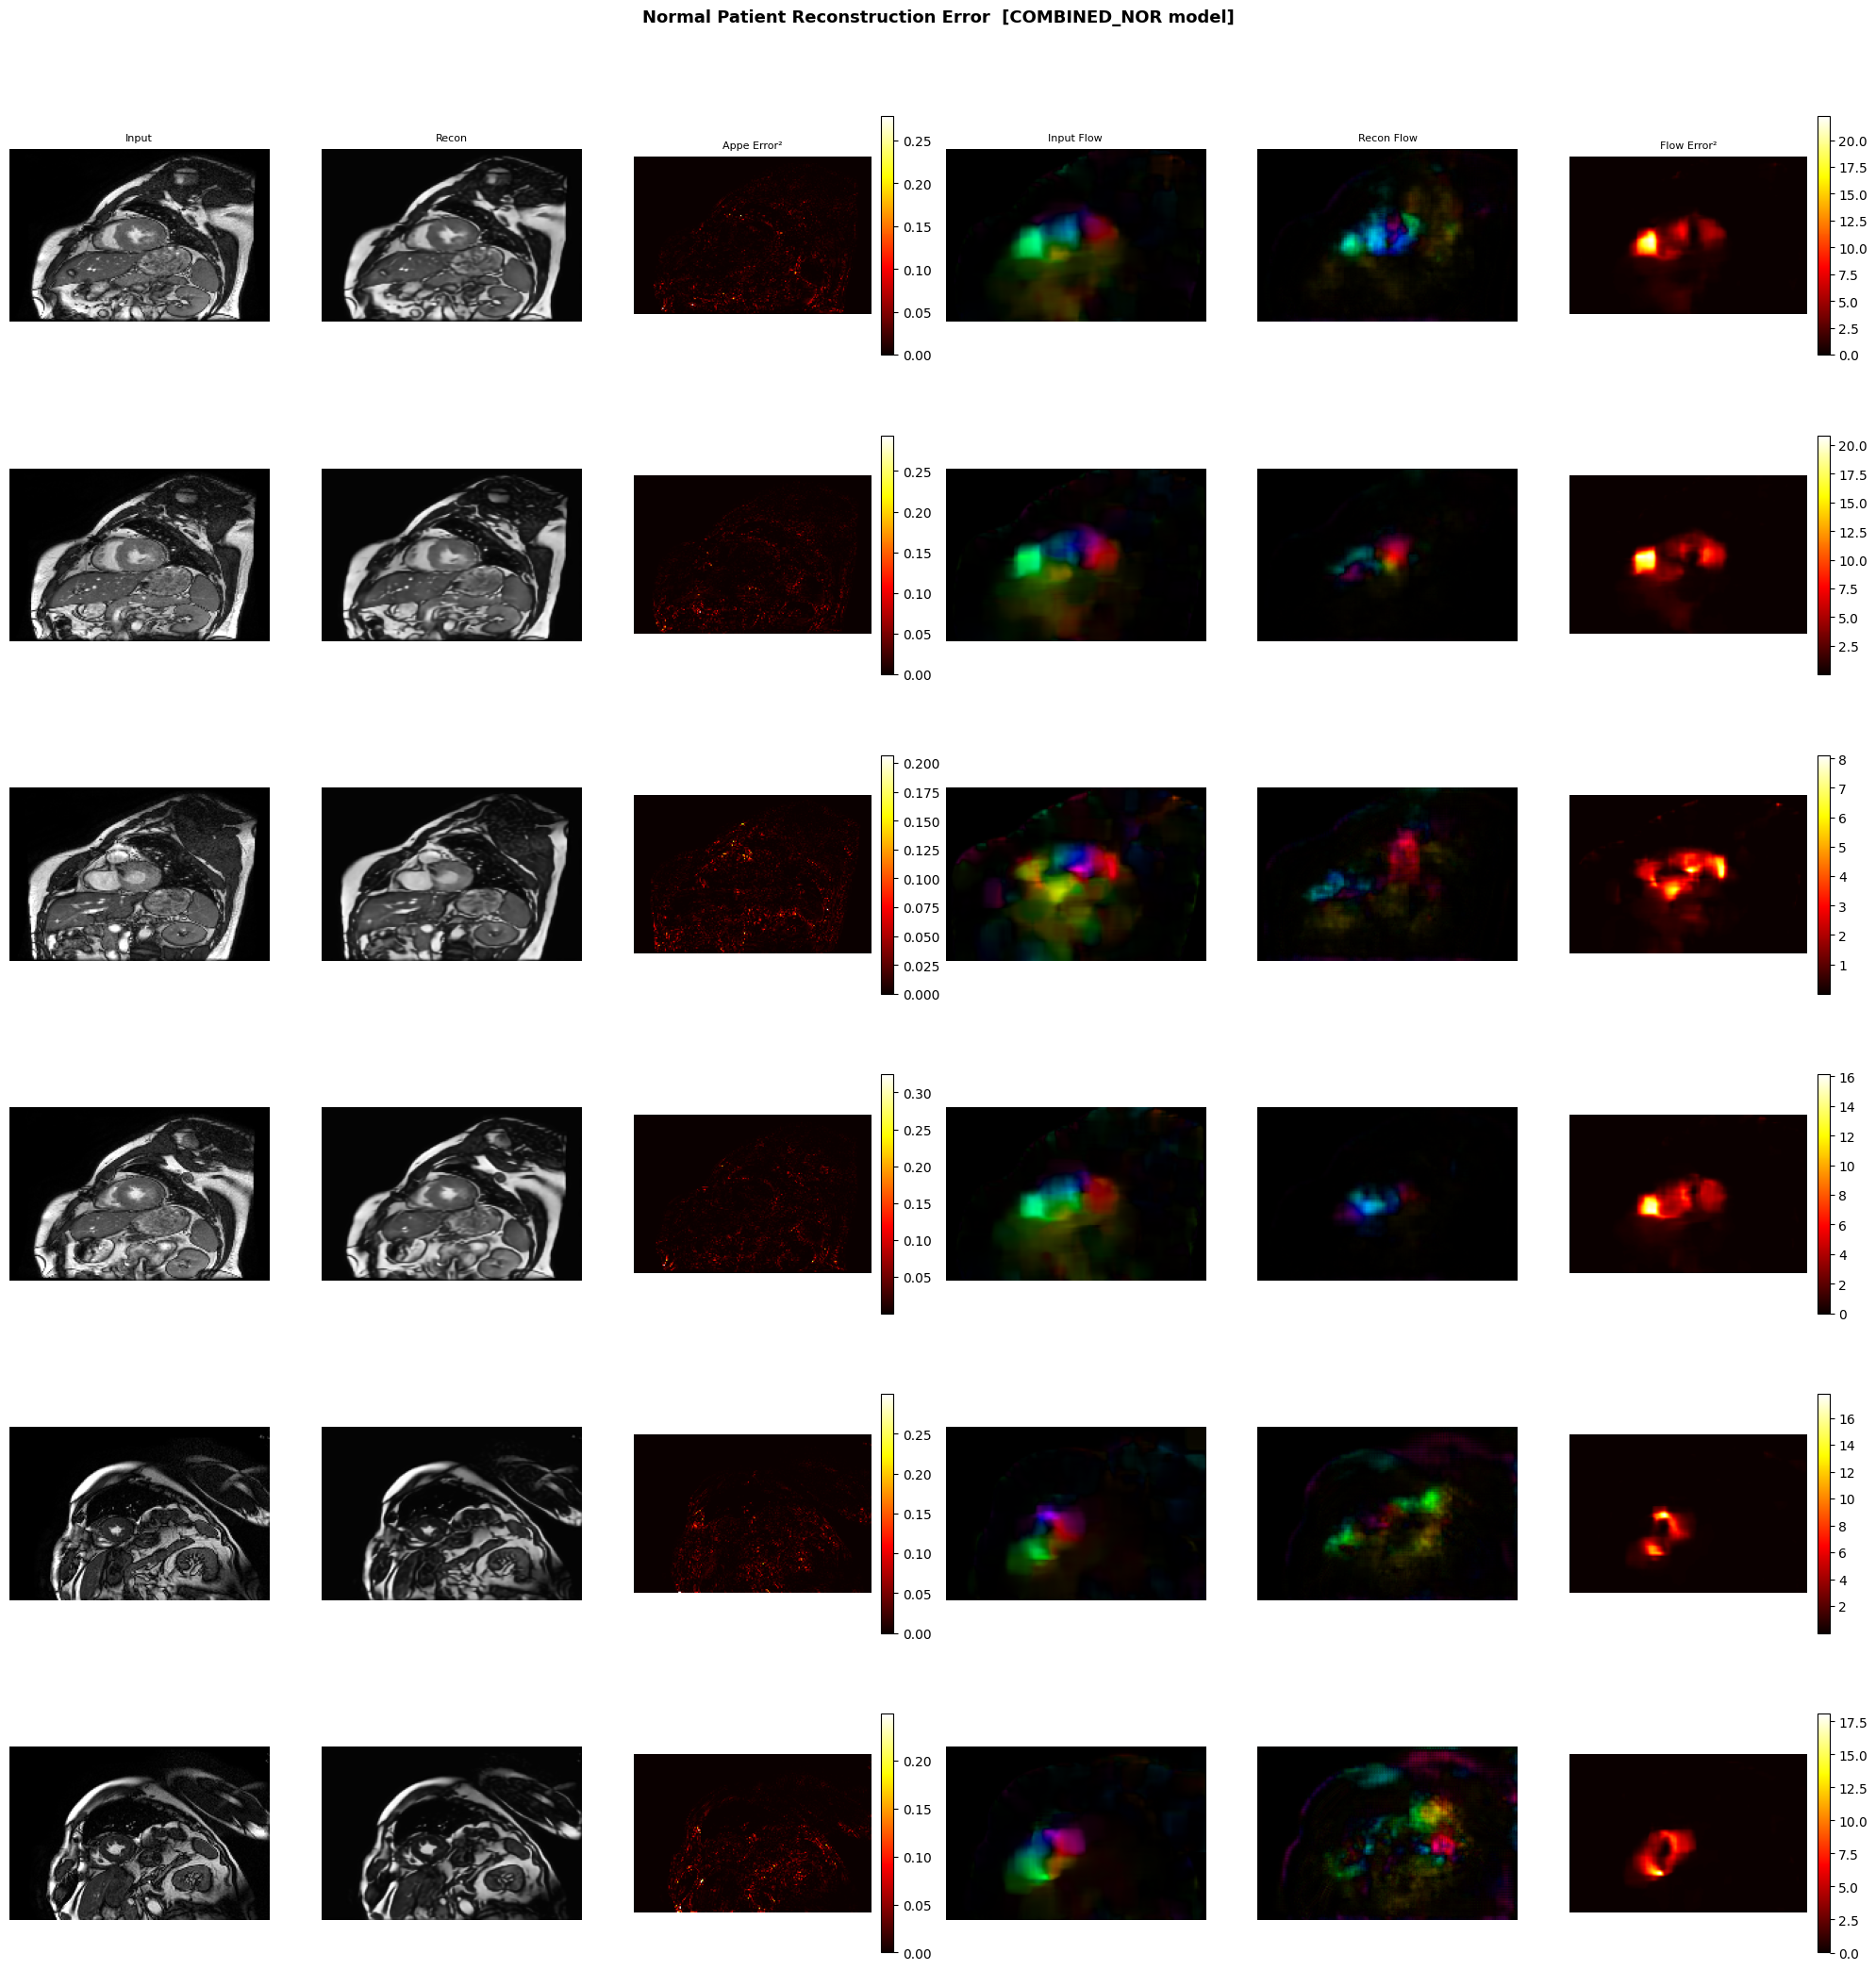

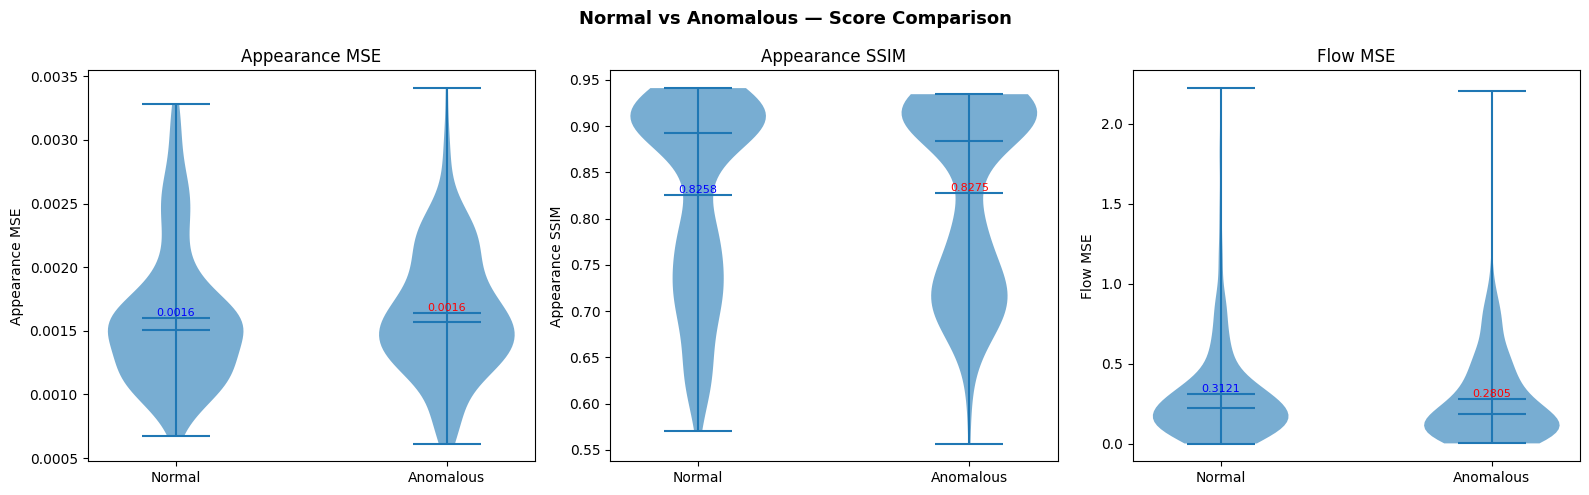


NORMAL vs ANOMALOUS  —  Key Metrics Comparison
            Metric |  Normal mean | Anomalous mean | Ratio (A/N)
---------------------------------------------------------------------------
    Appearance MSE |     0.001602 |       0.001644 |       1.026
   Appearance SSIM |     0.825775 |       0.827509 |       1.002
          Flow MSE |     0.312144 |       0.280545 |       0.899


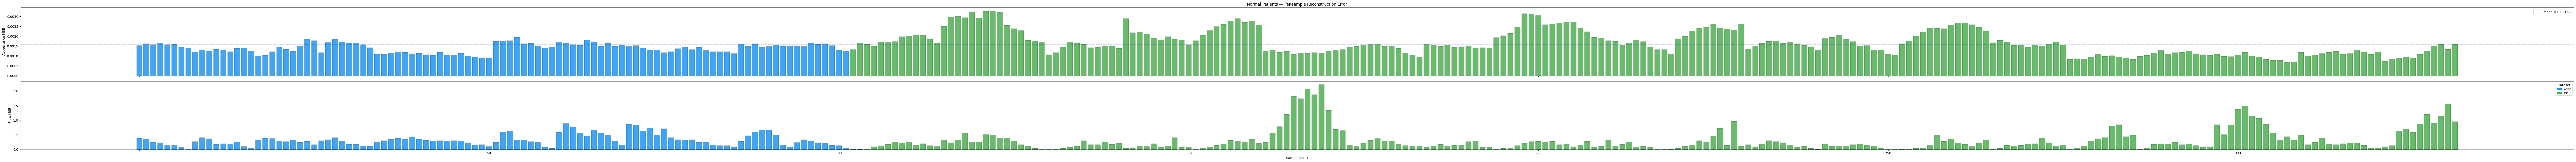

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# =============================================================================
# 1.  Error-map grid for normal samples (top 6 by MSE)
# =============================================================================
def flow_to_color_nor(flow_3ch):
    dx, dy = flow_3ch[..., 0], flow_3ch[..., 1]
    mag, ang = cv2.cartToPolar(dx, dy)
    hsv = np.zeros((*dx.shape, 3), dtype=np.float32)
    hsv[..., 0] = ang / (2 * np.pi)
    hsv[..., 1] = 1.0
    hsv[..., 2] = mag / (np.max(mag) + 1e-8)
    return mcolors.hsv_to_rgb(hsv)

N_SHOW = min(6, len(nor_images))
nor_appe_mse = nor_scores[:, 0, 4]
sorted_idx_nor = np.argsort(nor_appe_mse)[::-1][:N_SHOW]

row_titles = ['Input', 'Recon', 'Appe Error²', 'Input Flow', 'Recon Flow', 'Flow Error²']

fig, axes = plt.subplots(N_SHOW, 6, figsize=(20, 3.5 * N_SHOW))
if N_SHOW == 1:
    axes = axes[np.newaxis, :]
for row, i in enumerate(sorted_idx_nor):
    m = nor_meta[i]
    label = (f"{m['dataset']} {m['subject_id']} z={m['z_slice']}  "
             f"PSNR={m['appe_PSNR']:.1f}  SSIM={m['appe_SSIM']:.3f}  MSE={m['appe_MSE']:.5f}")
    imgs_row = [
        nor_images[i],
        nor_recon_images[i],
        np.mean((nor_images[i] - nor_recon_images[i])**2, -1),
        flow_to_color_nor(nor_flows[i]),
        flow_to_color_nor(nor_recon_flows[i]),
        np.mean((nor_flows[i] - nor_recon_flows[i])**2, -1),
    ]
    for col in range(6):
        ax = axes[row, col]
        img = imgs_row[col]
        if col in (0, 1):
            ax.imshow(np.clip(img, 0, 1))
        elif col in (3, 4):
            ax.imshow(img)
        else:
            im = ax.imshow(img, cmap='hot')
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        if row == 0:
            ax.set_title(row_titles[col], fontsize=8)
        ax.axis('off')
    axes[row, 0].set_ylabel(label, fontsize=6.5, rotation=0, labelpad=180, va='center')

plt.suptitle('Normal Patient Reconstruction Error  [COMBINED_NOR model]',
             fontweight='bold', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# =============================================================================
# 2.  Comparison: Normal vs Anomalous (if anomalous scores exist)
# =============================================================================
try:
    _ = all_scores  # from the anomalous section (cell 22)
    has_anom = True
except NameError:
    has_anom = False

if has_anom:
    fig2, axes2 = plt.subplots(1, 3, figsize=(16, 5))

    metrics = [('Appearance MSE', 0, 4),
               ('Appearance SSIM', 0, 3),
               ('Flow MSE', 1, 4)]

    for ax, (title, ch, sc) in zip(axes2, metrics):
        nor_vals  = nor_scores[:, ch, sc]
        anom_vals = all_scores[:, ch, sc]

        parts = ax.violinplot([nor_vals, anom_vals], positions=[0, 1],
                              showmeans=True, showmedians=True)
        for pc in parts['bodies']:
            pc.set_alpha(0.6)

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Normal', 'Anomalous'])
        ax.set_title(title)
        ax.set_ylabel(title)

        # Annotate means
        ax.text(0, nor_vals.mean(), f'{nor_vals.mean():.4f}',
                ha='center', va='bottom', fontsize=8, color='blue')
        ax.text(1, anom_vals.mean(), f'{anom_vals.mean():.4f}',
                ha='center', va='bottom', fontsize=8, color='red')

    plt.suptitle('Normal vs Anomalous — Score Comparison',
                 fontweight='bold', fontsize=13)
    plt.tight_layout()
    plt.show()

    # ── Summary statistics ───────────────────────────────────────────────
    print("\n" + "=" * 75)
    print("NORMAL vs ANOMALOUS  —  Key Metrics Comparison")
    print("=" * 75)
    print(f"{'Metric':>18s} | {'Normal mean':>12s} | {'Anomalous mean':>14s} | {'Ratio (A/N)':>11s}")
    print("-" * 75)
    for label, ch, sc in metrics:
        n_mean = nor_scores[:, ch, sc].mean()
        a_mean = all_scores[:, ch, sc].mean()
        ratio  = a_mean / n_mean if abs(n_mean) > 1e-12 else float('inf')
        print(f"{label:>18s} | {n_mean:12.6f} | {a_mean:14.6f} | {ratio:11.3f}")
    print("=" * 75)
else:
    print("(Run the anomalous scoring cells 19-23 first to enable Normal vs Anomalous comparison.)")

# =============================================================================
# 3.  Bar chart of normal sample scores (by dataset)
# =============================================================================
ds_colors = {'ACDC': '#2196F3', 'MM': '#4CAF50'}
fig3, (ax_a, ax_f) = plt.subplots(2, 1, figsize=(max(10, n_nor // 3), 7), sharex=True)
x = np.arange(n_nor)
colors = [ds_colors.get(m['dataset'], 'gray') for m in nor_meta]

ax_a.bar(x, nor_scores[:, 0, 4], color=colors, alpha=0.85, edgecolor='k', lw=0.3)
ax_a.set_ylabel('Appearance MSE')
ax_a.set_title('Normal Patients — Per-sample Reconstruction Error')
ax_a.axhline(nor_scores[:, 0, 4].mean(), ls='--', color='navy', lw=1,
             label=f'Mean = {nor_scores[:, 0, 4].mean():.5f}')
ax_a.legend()

ax_f.bar(x, nor_scores[:, 1, 4], color=colors, alpha=0.85, edgecolor='k', lw=0.3)
ax_f.set_ylabel('Flow MSE')
ax_f.set_xlabel('Sample index')
legend_elems = [Patch(facecolor=c, label=ds) for ds, c in ds_colors.items()]
ax_f.legend(handles=legend_elems, title='Dataset', fontsize=8)
plt.tight_layout()
plt.show()
